# Assignment-2 EE 769
## Classification and Feature Engineering
### Name: Vaishnav V. Rao
### Roll: 190260045

# Objective 1:
## Learn various steps and due diligence needed to train successful classification models.

In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 1) Read Training data

In [2]:
#read the data file and store in a pandas data frame
df= pd.read_csv('MouseTrain.csv') 

# 2) Usable variables

## Get rid of proteins with lots of missing values

In [3]:
#Find proteins which have a lot of missing values

#create an empty list to store relevant proteins
useless_proteins= []

for column in df.columns:
    #loop over the columns
    if df[column].isnull().sum()/len(df[column])>=0.2:
        #check if more than 20% of that particular protein's values are empty
        useless_proteins.append(column) #append protein to list of useless proteins

print("The following proteins have more than 20% of their values missing and will be dropped: ", useless_proteins)

#We will get rid of the useless proteins
df= df.drop(useless_proteins, axis=1)

The following proteins have more than 20% of their values missing and will be dropped:  ['BAD_N', 'BCL2_N', 'EGR1_N', 'H3MeK4_N']


## Get rid of proteins which have very low standard deviation

In [ ]:
#Find proteins which have very low variance

#create an empty list to store low variance proteins
lowvar_proteins= []

for column in df.columns[:-2]:
    #loop over the proteins
    if df[column].std()<0.02:
        #check if standard deviation is less than 0.05
        lowvar_proteins.append(column) #append protein to list of low variance proteins

print("The following proteins have standard deviation less than 0.02 and will be dropped: ", lowvar_proteins)

#We will get rid of these proteins
df=df.drop(lowvar_proteins, axis=1)

## Perform a t-test to see which proteins are important for classification
We will however not drop proteins because of this as multiple proteins together can classify the data well even though their individual t-tests are very low

In [5]:
#function to perform t-test on two classes. Each class can be a 2D array with columns as the features and rows as the samples
def t_test(class_A, class_B):
    #calculate mean vector amongst samples. axis=0 ensures mean is taken along the samples axis
    mean_A= np.mean(class_A, axis=0) 
    mean_B= np.mean(class_B, axis=0)
    
    #calculate the determinant of the covariance matrices
    var_A= np.linalg.det(np.atleast_2d(np.cov(class_A,ddof=1)))
    var_B= np.linalg.det(np.atleast_2d(np.cov(class_B,ddof=1)))
    
    #calculate size of each class
    n_A=np.ma.size(class_A,axis=0)
    n_B=np.ma.size(class_B,axis=0)
    
    #calculate the 't' metric
    t= np.linalg.norm(mean_A-mean_B)/np.sqrt((var_A/n_A)+(var_B/n_B))
    return t #returns the t-test
    

In [6]:
#test the above function

#create 2 sets of normal distributions centred around 1 and 2 with standard deviations 0.1 and 0.5

#std=0.1
class_1A=np.random.normal(1,0.1,1000)
class_1B=np.random.normal(2,0.1,500)

#std=0.5
class_2A=np.random.normal(1,0.5,500)
class_2B=np.random.normal(2,0.5,1000)

#perform t-test
t_test1= t_test(class_1A, class_1B)
t_test2= t_test(class_2A, class_2B)

#print results
print(t_test1, t_test2)

178.562268369543 35.25168705322102


The t-score of 1st set is larger than the t-score of the second set as expected. This is because the variance of the first set < variance of the second set, implying the classes are well separated.

In [7]:
#performs the t-test for all proteins using 'Genotype' classifier

#define empty list to store t-scores of different proteins
t_genotype=[]

protein_index=df.columns[:-2] #list of all proteins as last two columns are classes

#choose those indices for which class is 'Control' (A) or 'Ts65Dn' (B)
indices_A=np.where(df.loc[:,"Genotype"]=="Control")
indices_B=np.where(df.loc[:,"Genotype"]=="Ts65Dn")

for protein in protein_index:
    #loop over the proteins
    
    prot_data=df.loc[:,protein].values #convert the values of the protein to numpy array
    
    #select the protein values for each class
    class_A=prot_data[indices_A]
    class_B=prot_data[indices_B]
    
    #remove samples with 'nan' or missing values
    class_A=class_A[~np.isnan(class_A)]
    class_B=class_B[~np.isnan(class_B)]

    #compute t-score for the two classes of data and append to the t-score list
    t_genotype.append(t_test(class_A, class_B))
    
sorted_t_indices= np.argsort(t_genotype) #array of indices corresponding to increasing t-score values
print("The proteins with the highest t-scores in increasing order are: ", protein_index[sorted_t_indices[-5:]])


The proteins with the highest t-scores in increasing order are:  Index(['MTOR_N', 'pPKCG_N', 'S6_N', 'GluR3_N', 'APP_N'], dtype='object')


## Drop proteins which are highly correlated with other proteins
The following website was used as inspiration to find correlations using inbuilt functions in pandas: https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python

In [8]:
#Testing the Pearson's correlations between the proteins
corr= df.corr().abs() #pandas matrix containing absolute value of correlations amongst all proteins

#choose only the upper triangular matrix as the correlation matrix is symmetric
upper_triang= corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))

#select columns to drop that have atleast one entry with correlation > 0.9 
to_drop = [column for column in upper_triang.columns if any(upper_triang[column] > 0.9)]

#print the columns to be dropped
print("The following proteins are highly correlated with other proteins and will be dropped: ", to_drop)

#drop the highly correlated columns
df = df.drop(to_drop, axis=1)

The following proteins are highly correlated with other proteins and will be dropped:  ['ITSN1_N', 'pERK_N', 'pNR1_N', 'pNR2B_N', 'BRAF_N', 'Bcatenin_N']


None of these highly correlated proteins are the ones with high t-tests

## Are the classes balanced?

In [9]:
#Check if the classes are balanced or not

#Genotype: fraction of data points for each class 
genotype_counts= df["Genotype"].value_counts()/df["Genotype"].value_counts().sum()
print("Genotype class: \n", genotype_counts) #print the results

#Treatment_behaviour: fraction of data points for each class 
behaviour_counts= df["Treatment_Behavior"].value_counts()/df["Treatment_Behavior"].value_counts().sum()
print("Treatment and behavious class: \n", behaviour_counts)

Genotype class: 
 Control    0.570866
Ts65Dn     0.429134
Name: Genotype, dtype: float64
Treatment and behavious class: 
 Memantine_C/S    0.295276
Memantine_S/C    0.295276
Saline_C/S       0.236220
Saline_S/C       0.173228
Name: Treatment_Behavior, dtype: float64


The Genotype class is fairly balanced and so is the Treatment and Behaviour class

# 3) Imputing missing variables
A multivariate imputation strategy is used as in https://scikit-learn.org/stable/modules/impute.html

In [10]:
#Multivariate imputation of missing data
impute = IterativeImputer(max_iter=10, random_state=0) #initialize the iterative imputer
impute.fit(df[df.columns[:-2]]) #train the multivariate imputation model on all the data of the proteins. [:-2] chooses all columns except the last 2 as they are classes

df.iloc[:,:-2]= impute.transform(df[df.columns[:-2]]) #fill up the missing values based on the trained model and replace the protein data

In [15]:
#Normalize the features

#Import necessary library
from sklearn.preprocessing import StandardScaler

#Normalize the proteins columns
columns_to_normalize = df.columns[:-2]
scaler = StandardScaler()
scaler.fit(df[columns_to_normalize])
df[columns_to_normalize] = scaler.transform(df[columns_to_normalize])
#The same normalisation parameters will be used to normalise the test data later on

# Metrics to be used:

- For the first class of Genotype, there are two classes - Diseased and Healthy. Based on the protein values, we look to classify the mice into these two categories. We want to decrease the risk of false negatives as it is worse to classify diseased mice as healthy (and preventing them from treatment). The classes are also more or less balanced. Hence we will use the **Recall** metric for this class as it reduces false negatives.
- For the second class Treatment_Behaviour, there are four classes of different treatment and behaviour outcomes (roughly balanced). Thus, a positive or a negative interpretation is highly subjective and we look for just being able to differentiate between each class in balanced classification. That is why we will use the **F1** metric for this class. Moreover, if a one-vs-all strategy is used for this multi-class class, the classes will be heavily imbalanced, in which case F1 score can still be used for these imbalanced classes.

Reference- https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd

# Encoding of data
Reference- https://www.geeksforgeeks.org/how-to-convert-categorical-variable-to-numeric-in-pandas/

The above reference was used to see the syntax of encoding categorical data to numbers.

In [16]:
df_encoded=df #make a copy of the dataset to encode

#Replace the two classes of Genotype class with 0,1
df_encoded['Genotype'].replace(['Control', 'Ts65Dn'], [0, 1], inplace=True) 

#Replace the four classes of Treatment_Behaviour class with 0,1,2,3
df_encoded['Treatment_Behavior'].replace(['Memantine_C/S', 'Memantine_S/C', 'Saline_C/S', 'Saline_S/C'], [0, 1, 2, 3], inplace=True)

We can see that Genotype got split into two columns (as binary) and Treatment_Behavior got split into 4 columns (as four classes)

# Five fold cross validation

Five-fold cross-validation is a commonly used technique for evaluating the performance of a machine learning model. It involves splitting the dataset into five equal parts (or "folds"), and then training the model on four of the folds while using the remaining fold for testing. This process is repeated five times, with each fold used for testing exactly once. The performance of the model is then averaged across the five folds.

# 5a) Linear SVM with regularization as hyperparameter
5-fold cross validation used of GridSearch CV of Scikit

Reference for SVC (linear kernel)- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

Reference for GridSearchCV- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

## Classification of Genotype Class


In [17]:
#Import the necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import KFold

# X: rows- samples, columns- features/dimensions
X= df.iloc[:,:-2].values #selects the 2D matrix of all useful protein values

#y1: target data for the binary classification
y1= df_encoded['Genotype'].values

# Define model and hyperparameters
model = SVC(kernel='linear')
params = {'C': [0.1,1,10,100,1000,10000]}

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=37)

# Define GridSearchCV object with scoring strategy-'recall'
lin_genotype = GridSearchCV(model, param_grid=params, cv=cv, scoring='recall')

# Fit GridSearchCV object
lin_genotype.fit(X, y1)

# Evaluate results
print("Best hyperparameters: ", lin_genotype.best_params_)
print("Best score: ", lin_genotype.best_score_)

Best hyperparameters:  {'C': 1}
Best score:  0.963100155954338


# Result
Thus the optimal hyperparameter: C (inverse of lambda-the regularization parameter) which optimizes recall is 1. The corresponding recall value is 0.963

## Classification of Treatment_Behavior Class

By default, the SVC classifier with kernel='linear' in scikit-learn implements the One-vs-One (OvO) strategy to handle multiclass classification problems.

In the OvO strategy, the classifier constructs a binary classification problem for each pair of classes, resulting in n_classes * (n_classes - 1) / 2 binary classifiers for a problem with n_classes classes. During the training phase, each binary classifier is trained on a subset of the training data that consists of the examples from two classes.

To make a prediction on a new example, each binary classifier produces a vote for one of the two classes in the pair. The class with the most votes is selected as the predicted class. If there is a tie between two classes, the class with the higher decision function value is selected.

References:

[1]- https://scikit-learn.org/stable/modules/svm.html#multi-class-classification

[2]- https://sebastianraschka.com/faq/docs/svm-multiclass.html

In [18]:
# X: rows- samples, columns- features/dimensions
X= df.iloc[:,:-2].values #selects the 2D matrix of all useful protein values

#y2: target data for multiclass classification
y2= df_encoded['Treatment_Behavior'].values

# Define the hyperparameter grid
param_grid = {'C': [0.1,1,10,100,1000,10000]}

#Define the estimator
svm = SVC(kernel='linear') # multi-class classification strategy is one-vs-rest

# Define the cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the GridSearchCV object
lin_treatment = GridSearchCV(svm, param_grid=param_grid, scoring='f1_weighted', cv=cv)  #scoring startegy is weighted F1

# Fit the GridSearchCV object to the data
lin_treatment.fit(X, y2)

# Print the best parameters and the corresponding score
print('Best parameters:', lin_treatment.best_params_)
print('Best score:', lin_treatment.best_score_)

Best parameters: {'C': 10}
Best score: 0.9882262305413112


# Result
Thus the optimal hyperparameter: C (inverse of lambda-the regularization parameter) which optimizes F1 score is 10. The corresponding F1 score is 0.988

# 5b) RBF kernel SVM with kernel width and regularization as hyperparameters
5-fold cross validation used of GridSearch CV of Scikit

- RBF stands for Radial Basis Functions.
- They kernels calculate the Euclidian distance between two data points in a high dimensional feature space.
- The hyperparameter 'gamma' determines the widths of these kernel functions
- The hyperparamter 'C' again gives the inverse of regularization

Reference for SVC with RBF kernel- 

[1]- https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

[2]- https://towardsdatascience.com/svm-classifier-and-rbf-kernel-how-to-make-better-models-in-python-73bb4914af5b

## Classification of the Genotype Class

In [19]:
from sklearn.svm import SVC

#X: rows- samples, columns- features/dimensions
X= df.iloc[:,:-2].values #selects the 2D matrix of all useful protein values

#y1: target data for the binary classification
y1= df_encoded['Genotype'].values

#Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

#Define a dictionary of hyperparameters to search over
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'gamma': [0.01, 0.1, 1, 10]}

#Create an instance of the SVM classifier
svm = SVC(kernel='rbf') #RBF kernels

#Create an instance of the GridSearchCV class
rbf_genotype = GridSearchCV(svm, param_grid, cv=cv, scoring='recall') #scoring strategy is 'recall'

#Fit the GridSearchCV object to the data
rbf_genotype.fit(X, y1)

# Print the best parameters and the corresponding score
print('Best parameters:', rbf_genotype.best_params_)
print('Best score:', rbf_genotype.best_score_)


Best parameters: {'C': 10, 'gamma': 0.01}
Best score: 0.9970588235294118


# Result
Thus the optimal hyperparameters are: 

- C (inverse of lambda-the regularization parameter) which optimizes recall is 10. 
- gamma (width of the RBF kernel) which optimizes recall is 0.01
- The corresponding optimized recall value is 0.997

## Classification of Treatment_Behavior

**Automatically takes care of multiple classes**

In [20]:
from sklearn.svm import SVC

# X: rows- samples, columns- features/dimensions
X= df.iloc[:,:-2].values #selects the 2D matrix of all useful protein values

#y2: target data for multiclass classification
y2= df_encoded['Treatment_Behavior'].values

#Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

#Define a dictionary of hyperparameters to search over
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'gamma': [0.01, 0.1, 1, 10]}

#Create an instance of the SVM classifier
svm = SVC(kernel='rbf') #RBF kernels, multi-class classification strategy is one-vs-rest

#Create an instance of the GridSearchCV class
rbf_treatment = GridSearchCV(svm, param_grid, cv=cv, scoring='f1_weighted') #scoring strategy is 'F1' (weighted)

# Fit the GridSearchCV object to the data
rbf_treatment.fit(X, y2)

# Print the best parameters and the corresponding score
print('Best parameters:', rbf_treatment.best_params_)
print('Best score:', rbf_treatment.best_score_)

Best parameters: {'C': 10, 'gamma': 0.01}
Best score: 0.997390509821124


# Result
Thus the optimal hyperparameters are: 

- C (inverse of lambda-the regularization parameter) which optimizes F1 score is 10. 
- gamma (width of the RBF kernel) which optimizes F1 score is 0.01
- The corresponding optimized F1 value is 0.997

# 5c) Neural network with single ReLU hidden layer and Softmax output
## Hyperparameters: number of neurons, weight decay
5-fold cross validation used of GridSearch CV of Scikit

References- 

[1] https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

[2] https://analyticsindiamag.com/a-beginners-guide-to-scikit-learns-mlpclassifier/


## Classification of Genotype Class

In [21]:
from sklearn.neural_network import MLPClassifier

#X: rows- samples, columns- features/dimensions
X= df.iloc[:,:-2].values #selects the 2D matrix of all useful protein values

#y1: target data for the binary classification
y1= df_encoded['Genotype'].values

#Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up the neural network classifier
neural_class = MLPClassifier(hidden_layer_sizes=(5,), activation='relu', solver='adam', max_iter=10000)

# Set up the hyperparameter grid
param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'hidden_layer_sizes': [(2,), (5,), (10,)]
}

#initialize GridSearchCV object
neural_genotype = GridSearchCV(neural_class, param_grid=param_grid, cv=cv, scoring='recall') #using scoring method of recall

#Fit the GridSearchCV object to the data
neural_genotype.fit(X, y1)

# Print the best parameters and best score
print(f"Best parameters: {neural_genotype.best_params_}")
print(f"Best score: {neural_genotype.best_score_:.2f}")


Best parameters: {'alpha': 0.001, 'hidden_layer_sizes': (5,)}
Best score: 0.99


# Result
Thus the optimal hyperparameters are: 

- Number of neurons (hideen_layer_sizes) which optimizes recall is 5. 
- Weight decay (alpha) optimizes recall is 0.001
- The corresponding optimized recall value is 0.99

## Classification of Treatment_Behavior

**Automatically takes care of multiple classes**

In [22]:
from sklearn.neural_network import MLPClassifier

# X: rows- samples, columns- features/dimensions
X= df.iloc[:,:-2].values #selects the 2D matrix of all useful protein values

#y2: target data for multiclass classification
y2= df_encoded['Treatment_Behavior'].values

#Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up the neural network classifier
neural_class = MLPClassifier(hidden_layer_sizes=(5,), activation='relu', solver='adam', max_iter=10000)

# Set up the hyperparameter grid
param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'hidden_layer_sizes': [(2,), (5,), (10,)]
}

#initialize GridSearchCV object
neural_treatment = GridSearchCV(neural_class, param_grid=param_grid, cv=cv, scoring='f1_weighted') #use weighted f1 score

#Fit the GridSearchCV object to the data
neural_treatment.fit(X, y2)

# Print the best parameters and best score
print(f"Best parameters: {neural_treatment.best_params_}")
print(f"Best score: {neural_treatment.best_score_:.2f}")


Best parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (10,)}
Best score: 0.99


# Result
Thus the optimal hyperparameters are: 

- Number of neurons (hideen_layer_sizes) which optimizes f1 score is 10. 
- Weight decay (alpha) optimizes f1 score is 0.0001
- The corresponding optimized f1 score value is 0.99

# 5d) Random forest
## Hyperparamters: Max tree depth, Max number of variables per node
5-fold cross validation used of GridSearch CV of Scikit

References:

[1]- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

[2]- https://scikit-learn.org/stable/modules/tree.html#tree-mathematical-formulation


## Classification of Genotype class

In [23]:
#import necessary library
from sklearn.ensemble import RandomForestClassifier

#X: rows- samples, columns- features/dimensions
X= df.iloc[:,:-2].values #selects the 2D matrix of all useful protein values

#y1: target data for the binary classification
y1= df_encoded['Genotype'].values

#Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up the Random Forest Classifier
rf_class = RandomForestClassifier(criterion='entropy') 

# Set up the hyperparameter grid
param_grid = {
    'max_depth': [1,10,20,30],
    'max_features': [1,10,20,30]
}

#initialize GridSearchCV object
rf_genotype = GridSearchCV(rf_class, param_grid=param_grid, cv=cv, scoring='recall') #using scoring method of recall

#Fit the GridSearchCV object to the data
rf_genotype.fit(X, y1)

# Print the best parameters and best score
print(f"Best parameters: {rf_genotype.best_params_}")
print(f"Best score: {rf_genotype.best_score_:.2f}")

Best parameters: {'max_depth': 30, 'max_features': 10}
Best score: 0.98


# Result
Thus the optimal hyperparameters are: 

- Max tree depth which optimizes recall is 30. 
- Max number of features which optimizes recall is 10
- The corresponding optimized recall value is 0.98

## Classification of Treatment_Behaviour class

In [24]:
#import necessary library
from sklearn.ensemble import RandomForestClassifier

# X: rows- samples, columns- features/dimensions
X= df.iloc[:,:-2].values #selects the 2D matrix of all useful protein values

#y2: target data for multiclass classification
y2= df_encoded['Treatment_Behavior'].values

#Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up the Random Forest Classifier
rf_class = RandomForestClassifier(criterion='entropy') 

# Set up the hyperparameter grid
param_grid = {
    'max_depth': [1,10,20,30],
    'max_features': [1,10,20,30]
}

#initialize GridSearchCV object
rf_treatment = GridSearchCV(rf_class, param_grid=param_grid, cv=cv, scoring='f1_weighted') #using F1 scoring

#Fit the GridSearchCV object to the data
rf_treatment.fit(X, y2)

# Print the best parameters and best score
print(f"Best parameters: {rf_treatment.best_params_}")
print(f"Best score: {rf_treatment.best_score_:.2f}")

Best parameters: {'max_depth': 20, 'max_features': 10}
Best score: 0.99


# Result
Thus the optimal hyperparameters are: 

- Max tree depth which optimizes F1 score is 20. 
- Max number of features which optimizes recall is 10
- The corresponding optimized recall value is 0.99

# 6) Feature importance

## a) Linear SVC:
In linear models, the absolute values of the weights of the feature/dimension is a measure of how important the feature is

## Genotype Class

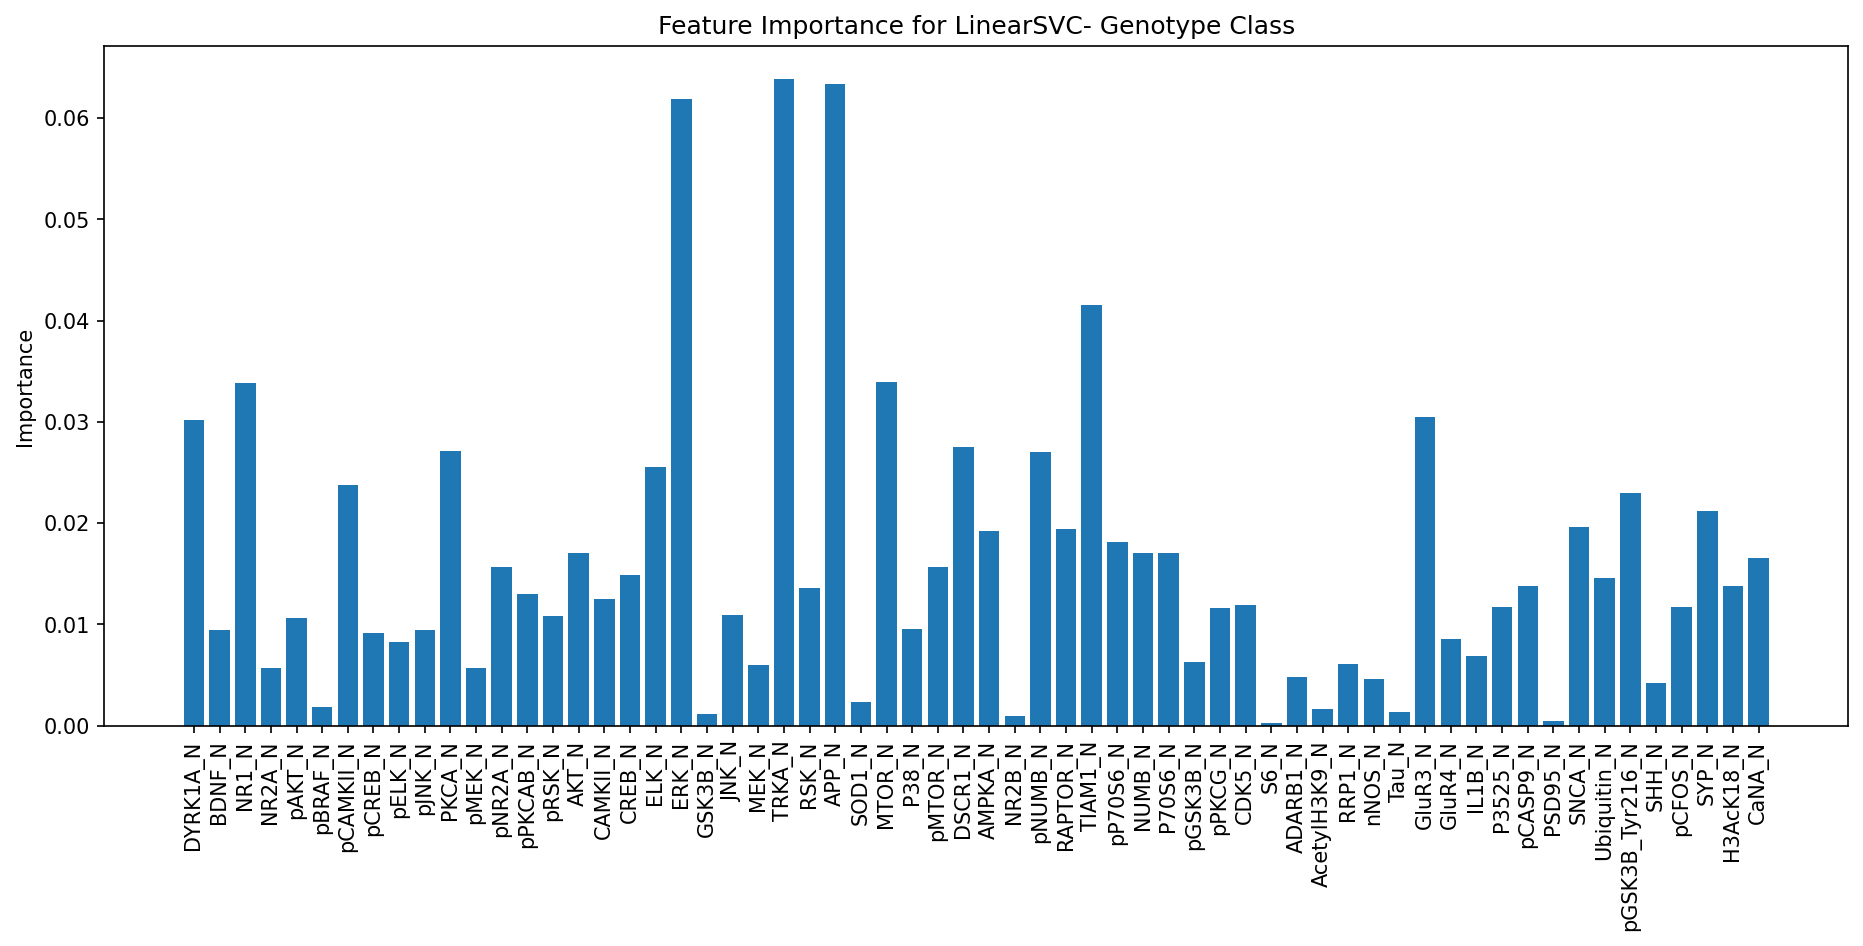

The proteins with the highest feature importance (in increasing order) are:  Index(['MTOR_N', 'TIAM1_N', 'ERK_N', 'APP_N', 'TRKA_N'], dtype='object')


In [26]:
# Retrieve the coefficients of the hyperplane from the trained Linear Classifier

best_estimator=lin_genotype.best_estimator_ #uses the best hyperparameters from the previously perfomed grid search operation
coef = best_estimator.coef_ #obtains the coeffiecients for that best hyperparameter model

# Get the absolute values of the coefficients and normalize them
importance = abs(coef) / abs(coef).sum()

# Create a horizontal bar graph of the feature/protein importances
proteins = df.columns[:-2]
y_pos = np.arange(len(proteins))

#Plotting and garnishing
plt.figure(figsize=(15,6), dpi=150)
plt.bar(y_pos, importance[0], align='center')
plt.xticks(y_pos, proteins, rotation=90)
plt.ylabel('Importance')
plt.title('Feature Importance for LinearSVC- Genotype Class')
plt.show()

sorted_importance_indices= np.argsort(importance[0]) #array of indices corresponding to increasing importance values
print("The proteins with the highest feature importance (in increasing order) are: ", proteins[sorted_importance_indices[-5:]])

## Treatment_Behavior Class

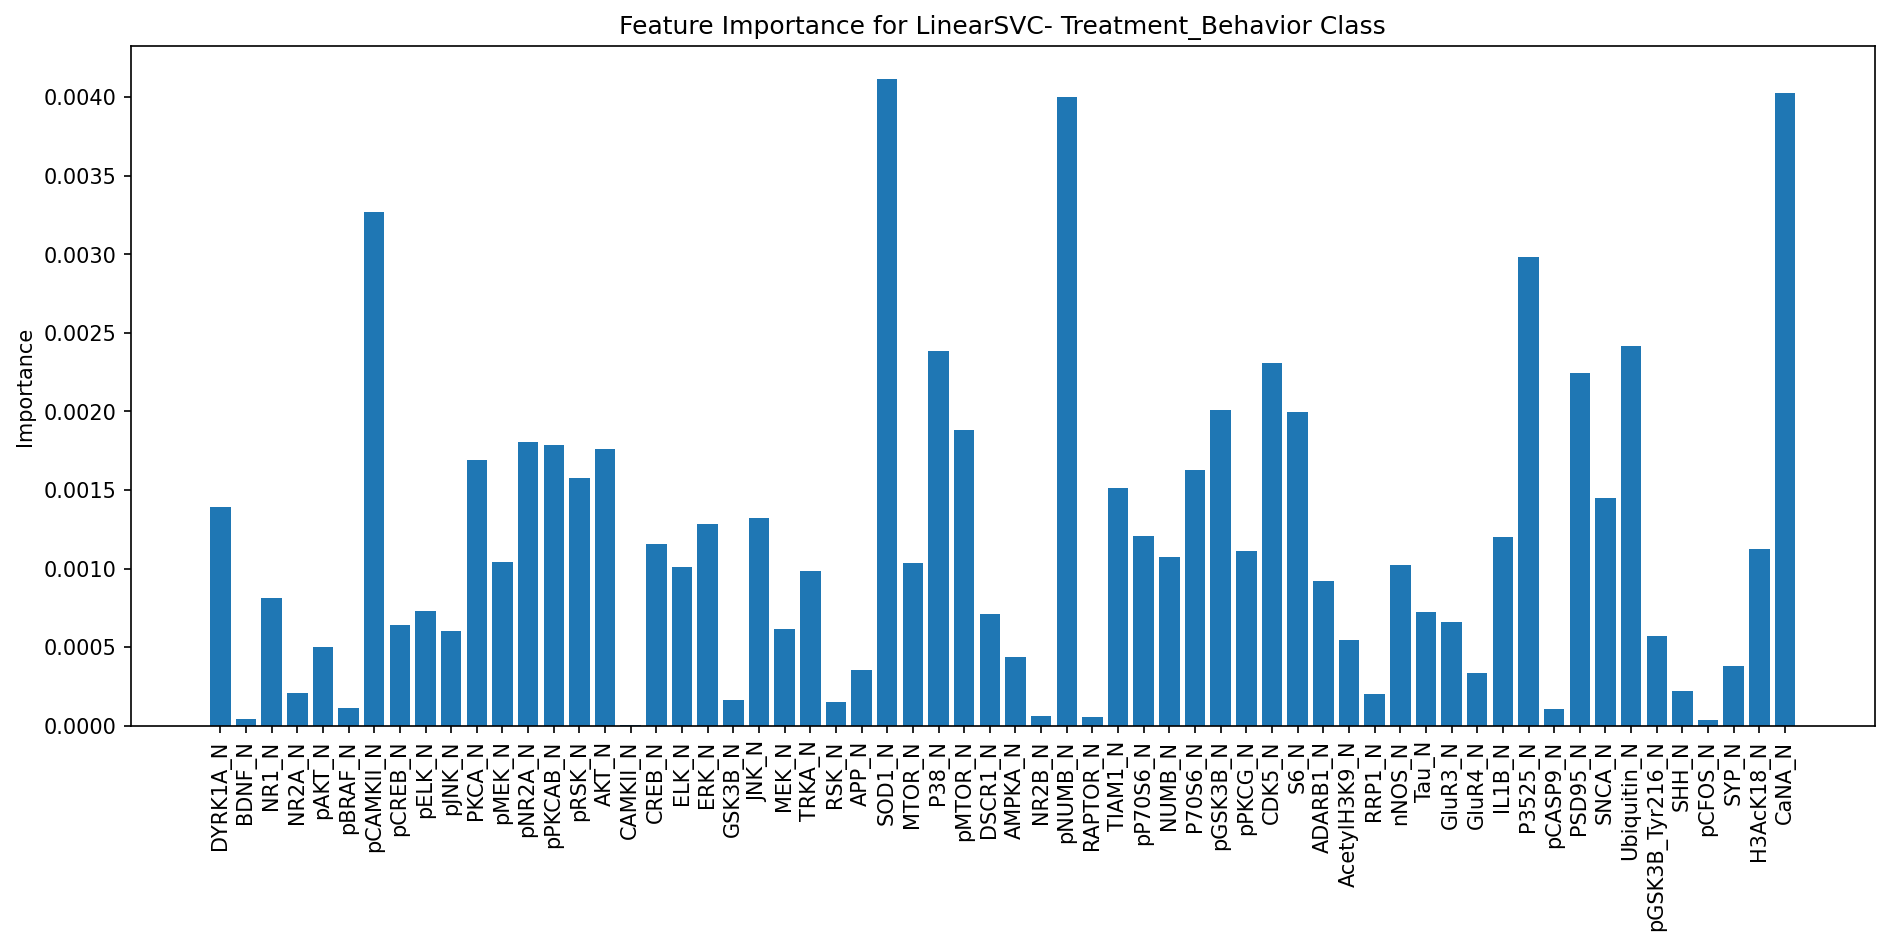

The proteins with the highest feature importance (in increasing order) are:  Index(['P3525_N', 'pCAMKII_N', 'pNUMB_N', 'CaNA_N', 'SOD1_N'], dtype='object')


In [27]:
# Retrieve the coefficients of the hyperplane from the trained Linear Classifier

best_estimator=lin_treatment.best_estimator_ #uses the best hyperparameters from the previously perfomed grid search operation
coef = best_estimator.coef_ #obtains the coeffiecients for that best hyperparameter model

# Get the absolute values of the coefficients and normalize them
importance = abs(coef) / abs(coef).sum()

# Create a horizontal bar graph of the feature/protein importances
proteins = df.columns[:-2]
y_pos = np.arange(len(proteins))

#Plotting and garnishing
plt.figure(figsize=(15,6), dpi=150)
plt.bar(y_pos, importance[0], align='center')
plt.xticks(y_pos, proteins, rotation=90)
plt.ylabel('Importance')
plt.title('Feature Importance for LinearSVC- Treatment_Behavior Class')
plt.show()

sorted_importance_indices= np.argsort(importance[0]) #array of indices corresponding to increasing importance values
print("The proteins with the highest feature importance (in increasing order) are: ", proteins[sorted_importance_indices[-5:]])

## b) RBF Kernel SVC

### Permutation feature importance

- The coefficients or dual coefficients of non-linear models cannot be easily interpreted as feature importances.
- Permutation importance is a model-agnostic method that works by randomly permuting the values of each feature in the test data and measuring the decrease in model performance that results from the permutation. This measures the contribution of each feature to the model's predictive accuracy, regardless of the specific model architecture or parameters.
- By comparing the decrease in accuracy for each feature, permutation importance provides a relative ranking of feature importances. This can help identify which features are most important for the model's performance.

References:
1. https://scikit-learn.org/stable/modules/permutation_importance.html
1. https://stackoverflow.com/questions/58926146/determining-the-most-contributing-features-for-non-linear-svm-regression-in-skl


## Genotype Class

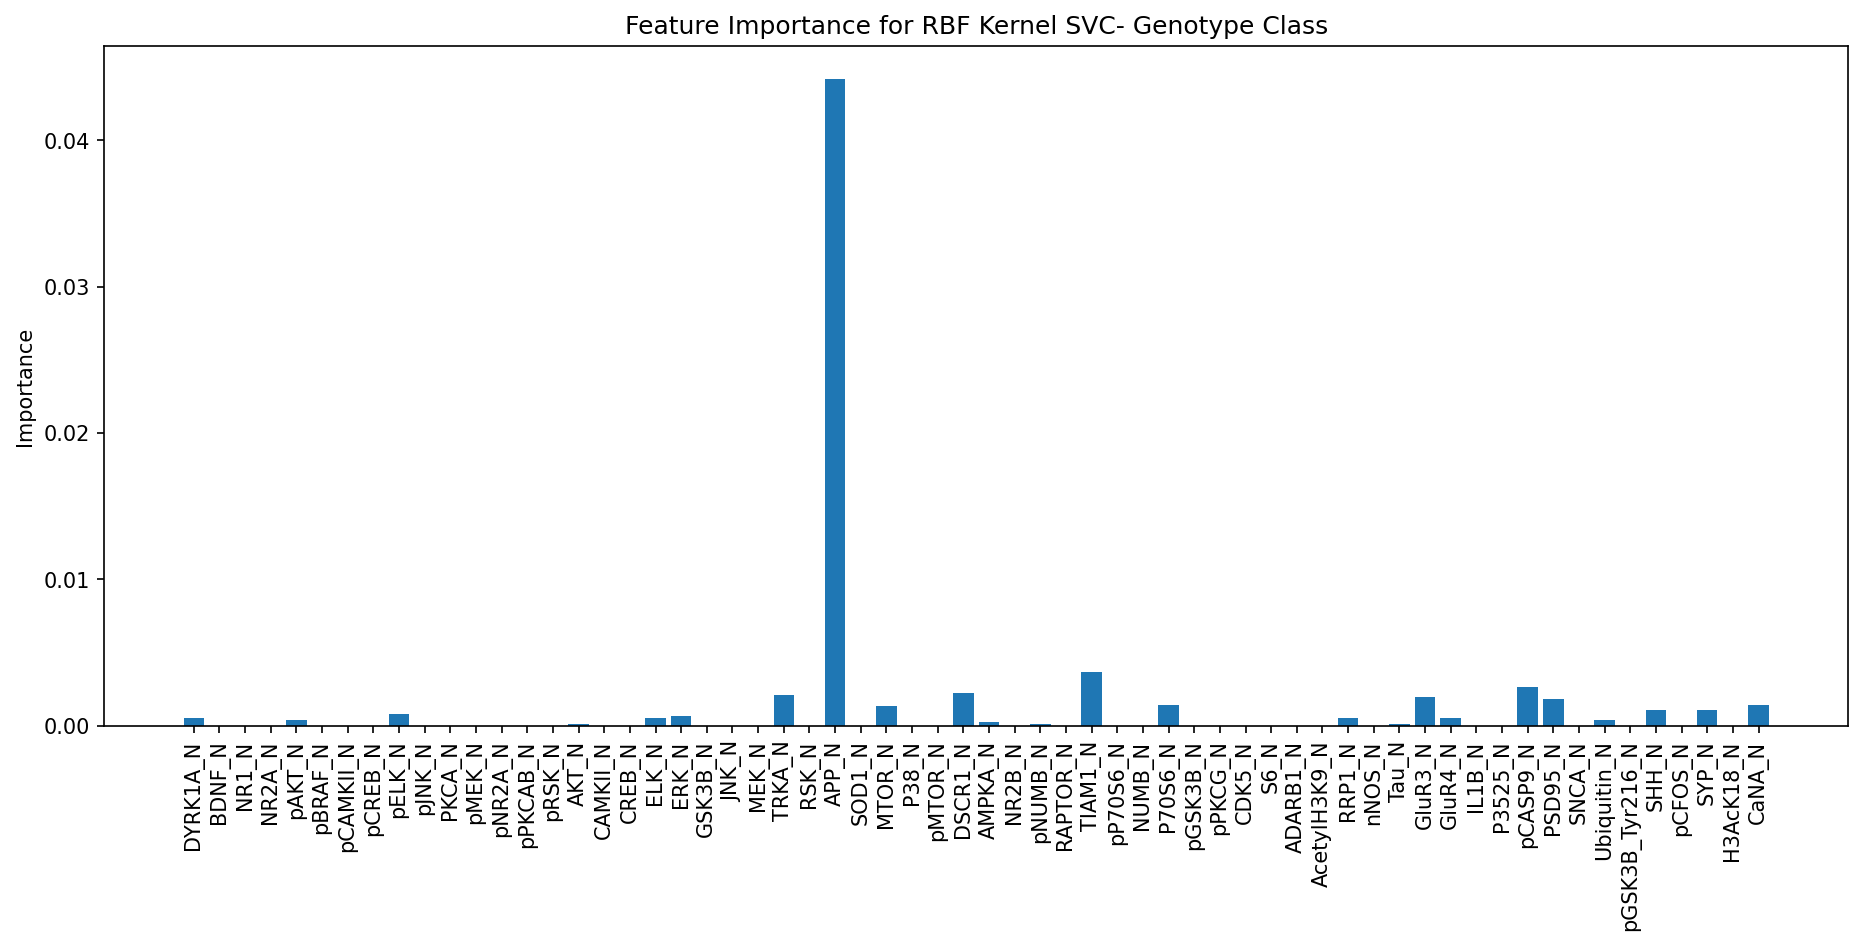

The proteins with the highest feature importance (in increasing order) are:  Index(['TRKA_N', 'DSCR1_N', 'pCASP9_N', 'TIAM1_N', 'APP_N'], dtype='object')


In [28]:
#Import necessary library
from sklearn.inspection import permutation_importance

#X: rows- samples, columns- features/dimensions
X= df.iloc[:,:-2].values #selects the 2D matrix of all useful protein values

#y1: target data for the binary classification
y1= df_encoded['Genotype'].values

best_estimator=rbf_genotype.best_estimator_ #uses the best hyperparameters from the previously perfomed grid search operation

#Calculate permutation importance. This object has many attributes including
#the mean and standard deviation of the feature importances computed over multiple repetitions
perm_importance = permutation_importance(best_estimator, X, y1, n_repeats=10, random_state=37)

#The importances_mean attribute is a 1D array with one element for each feature, 
#containing the estimated importance of each feature based on the permutation importance method.
rbf_gen_importance= perm_importance.importances_mean

# Create a horizontal bar graph of the feature/protein importances
proteins = df.columns[:-2]
y_pos = np.arange(len(proteins))

#Plotting and garnishing
plt.figure(figsize=(15,6), dpi=150)
plt.bar(y_pos, rbf_gen_importance, align='center')
plt.xticks(y_pos, proteins, rotation=90)
plt.ylabel('Importance')
plt.title('Feature Importance for RBF Kernel SVC- Genotype Class')
plt.show()

sorted_importance_indices= np.argsort(rbf_gen_importance) #array of indices corresponding to increasing importance values
print("The proteins with the highest feature importance (in increasing order) are: ", proteins[sorted_importance_indices[-5:]])

## Treatment_Behavior Class

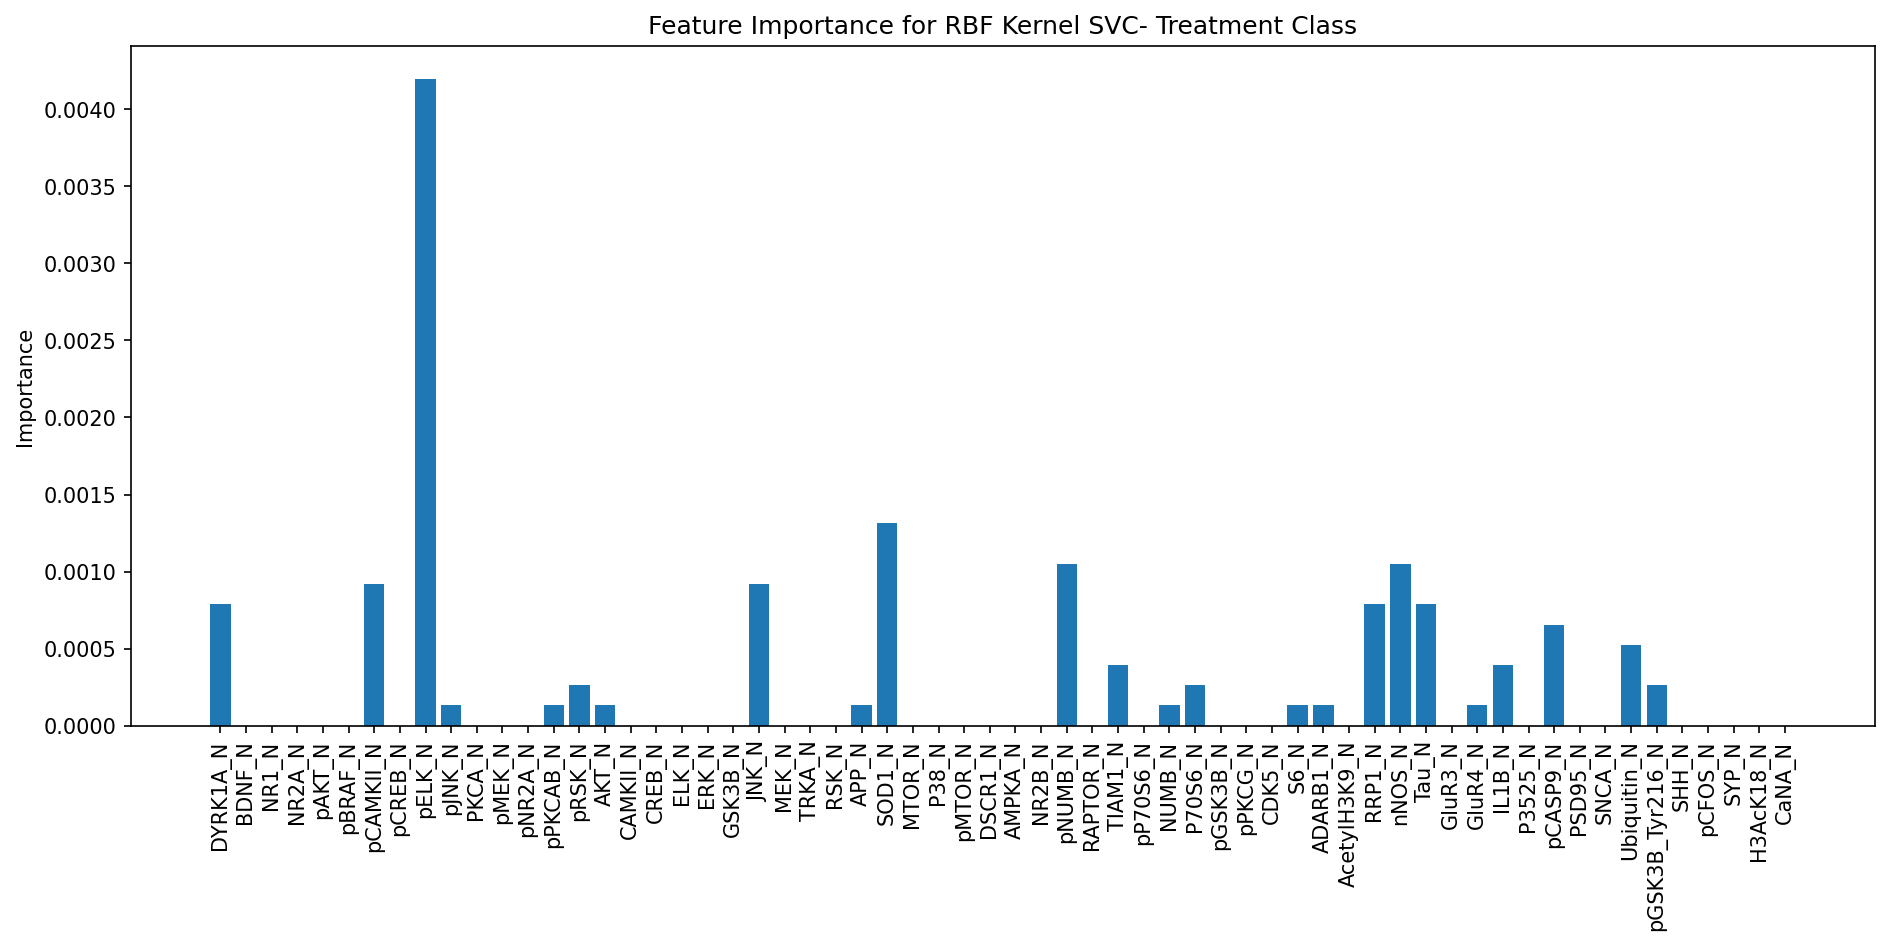

The proteins with the highest feature importance (in increasing order) are:  Index(['JNK_N', 'nNOS_N', 'pNUMB_N', 'SOD1_N', 'pELK_N'], dtype='object')


In [30]:
#Import necessary library
from sklearn.inspection import permutation_importance

#X: rows- samples, columns- features/dimensions
X= df.iloc[:,:-2].values #selects the 2D matrix of all useful protein values

#y2: target data for multiclass classification
y2= df_encoded['Treatment_Behavior'].values

best_estimator=rbf_treatment.best_estimator_ #uses the best hyperparameters from the previously perfomed grid search operation

#Calculate permutation importance. This object has many attributes including
#the mean and standard deviation of the feature importances computed over multiple repetitions
perm_importance = permutation_importance(best_estimator, X, y2, n_repeats=10, random_state=37)

#The importances_mean attribute is a 1D array with one element for each feature, 
#containing the estimated importance of each feature based on the permutation importance method.
rbf_treat_importance= perm_importance.importances_mean

# Create a horizontal bar graph of the feature/protein importances
proteins = df.columns[:-2]
y_pos = np.arange(len(proteins))

#Plotting and garnishing
plt.figure(figsize=(15,6), dpi=150)
plt.bar(y_pos, rbf_treat_importance, align='center')
plt.xticks(y_pos, proteins, rotation=90)
plt.ylabel('Importance')
plt.title('Feature Importance for RBF Kernel SVC- Treatment Class')
plt.show()

sorted_importance_indices= np.argsort(rbf_treat_importance) #array of indices corresponding to increasing importance values
print("The proteins with the highest feature importance (in increasing order) are: ", proteins[sorted_importance_indices[-5:]])

## c) Neural Network

As this is a nonlinear model, we will continue to use **permutation feature importance**

## Genotype Class

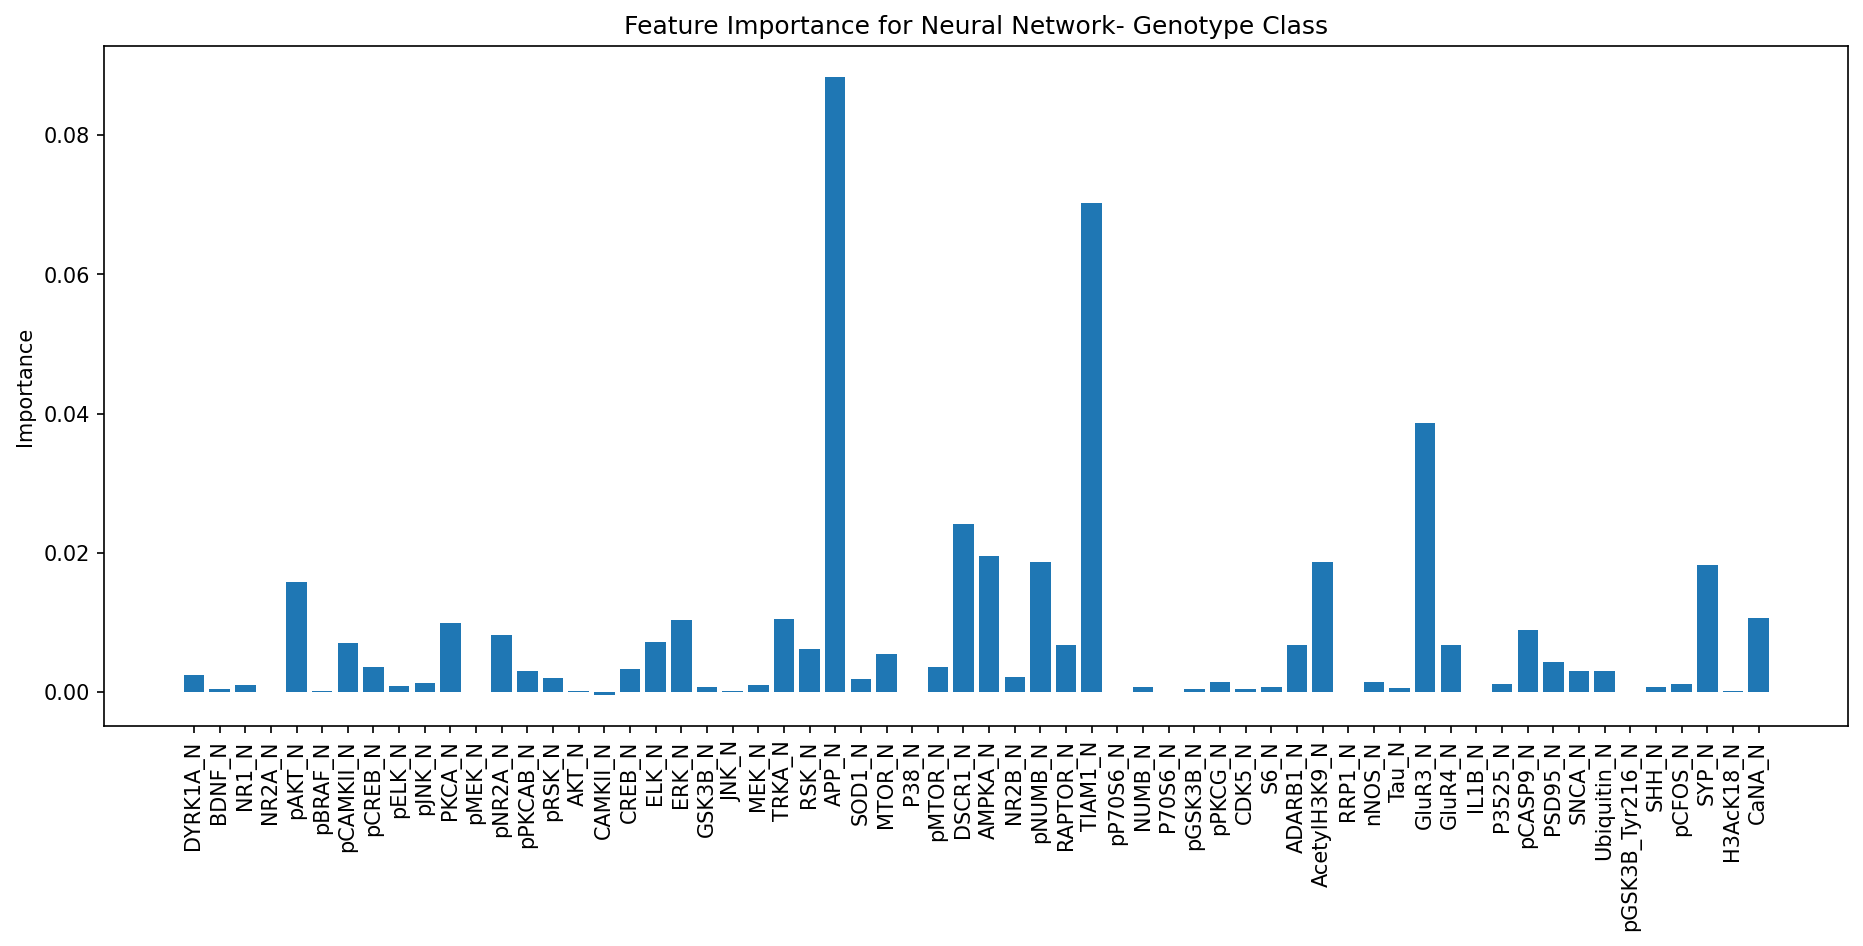

The proteins with the highest feature importance (in increasing order) are:  Index(['AMPKA_N', 'DSCR1_N', 'GluR3_N', 'TIAM1_N', 'APP_N'], dtype='object')


In [31]:
#Import necessary library
from sklearn.inspection import permutation_importance

#X: rows- samples, columns- features/dimensions
X= df.iloc[:,:-2].values #selects the 2D matrix of all useful protein values

#y1: target data for the binary classification
y1= df_encoded['Genotype'].values

#uses the best hyperparameters from the previously perfomed grid search operation and the trained neural network
best_estimator=neural_genotype.best_estimator_ 

#Calculate permutation importance. This object has many attributes including
#the mean and standard deviation of the feature importances computed over multiple repetitions
perm_importance = permutation_importance(best_estimator, X, y1, n_repeats=10, random_state=37)

#The importances_mean attribute is a 1D array with one element for each feature, 
#containing the estimated importance of each feature based on the permutation importance method.
neural_gen_importance= perm_importance.importances_mean

# Create a horizontal bar graph of the feature/protein importances
proteins = df.columns[:-2]
y_pos = np.arange(len(proteins))

#Plotting and garnishing
plt.figure(figsize=(15,6), dpi=150)
plt.bar(y_pos, neural_gen_importance, align='center')
plt.xticks(y_pos, proteins, rotation=90)
plt.ylabel('Importance')
plt.title('Feature Importance for Neural Network- Genotype Class')
plt.show()

sorted_importance_indices= np.argsort(neural_gen_importance) #array of indices corresponding to increasing importance values
print("The proteins with the highest feature importance (in increasing order) are: ", proteins[sorted_importance_indices[-5:]])

## Treatment_Behavior class

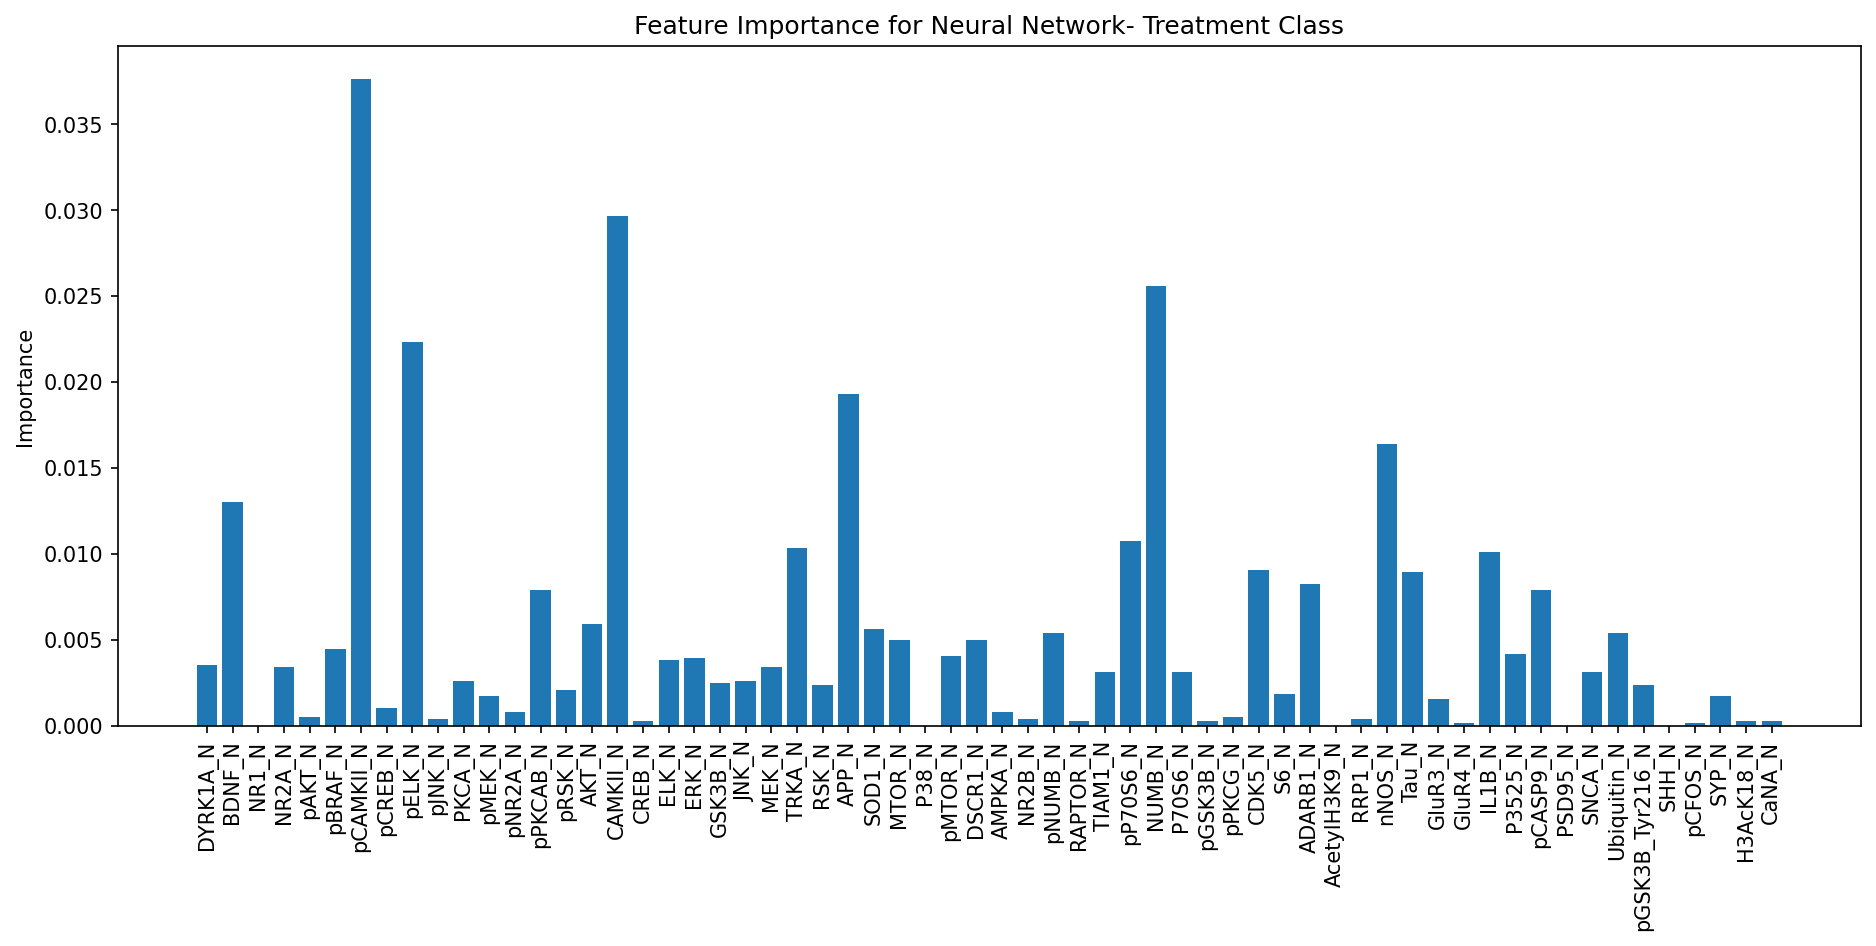

The proteins with the highest feature importance (in increasing order) are:  Index(['APP_N', 'pELK_N', 'NUMB_N', 'CAMKII_N', 'pCAMKII_N'], dtype='object')


In [32]:
#Import necessary library
from sklearn.inspection import permutation_importance

#X: rows- samples, columns- features/dimensions
X= df.iloc[:,:-2].values #selects the 2D matrix of all useful protein values

#y2: target data for multiclass classification
y2= df_encoded['Treatment_Behavior'].values

#uses the best hyperparameters from the previously perfomed grid search operation and the trained neural network
best_estimator=neural_treatment.best_estimator_ 

#Calculate permutation importance. This object has many attributes including
#the mean and standard deviation of the feature importances computed over multiple repetitions
perm_importance = permutation_importance(best_estimator, X, y2, n_repeats=10, random_state=37)

#The importances_mean attribute is a 1D array with one element for each feature, 
#containing the estimated importance of each feature based on the permutation importance method.
neural_treat_importance= perm_importance.importances_mean

# Create a horizontal bar graph of the feature/protein importances
proteins = df.columns[:-2]
y_pos = np.arange(len(proteins))

#Plotting and garnishing
plt.figure(figsize=(15,6), dpi=150)
plt.bar(y_pos, neural_treat_importance, align='center')
plt.xticks(y_pos, proteins, rotation=90)
plt.ylabel('Importance')
plt.title('Feature Importance for Neural Network- Treatment Class')
plt.show()

sorted_importance_indices= np.argsort(neural_treat_importance) #array of indices corresponding to increasing importance values
print("The proteins with the highest feature importance (in increasing order) are: ", proteins[sorted_importance_indices[-5:]])

## d) Random Forest
We will use the inbuilt function of the trained Random Forest Classifier model to obtain feature importance- (feature_importances_)


## Genotype Class

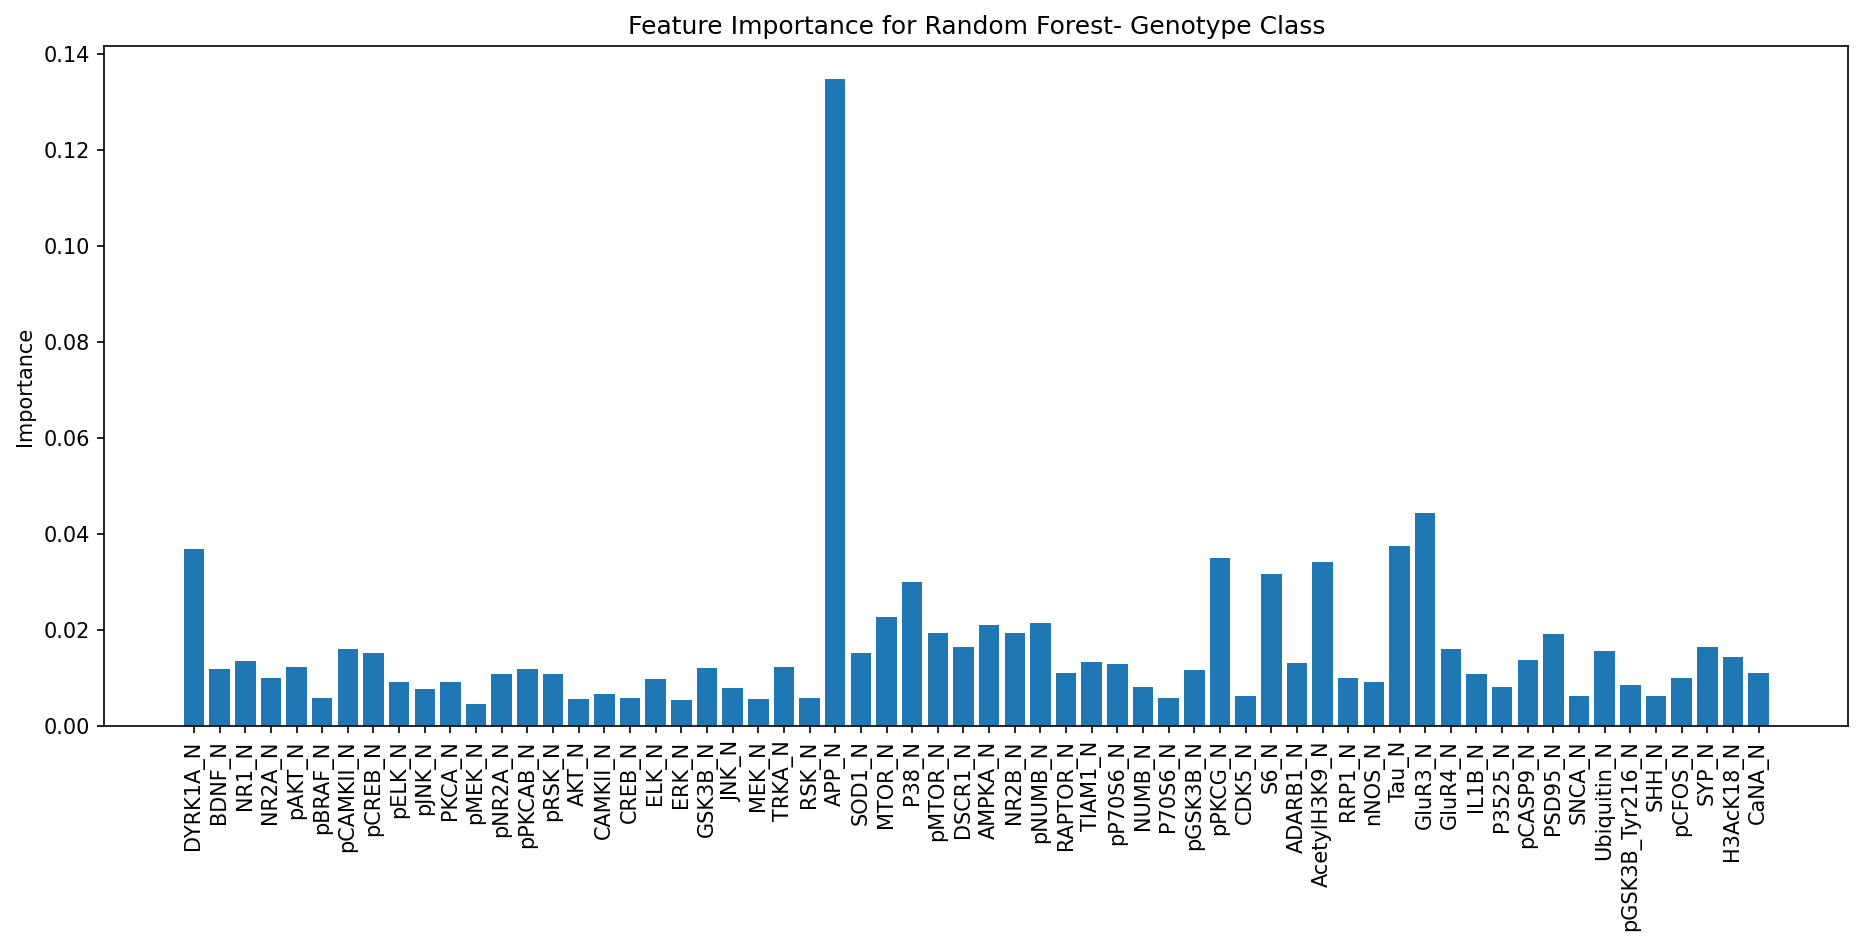

The proteins with the highest feature importance (in increasing order) are:  Index(['pPKCG_N', 'DYRK1A_N', 'Tau_N', 'GluR3_N', 'APP_N'], dtype='object')


In [33]:
#uses the best hyperparameters from the previously perfomed grid search operation and the trained random forest classifier
best_estimator=rf_genotype.best_estimator_ 

#obtain feature importance from built in function
rf_importance= best_estimator.feature_importances_

# Create a horizontal bar graph of the feature/protein importances
proteins = df.columns[:-2]
y_pos = np.arange(len(proteins))

#Plotting and garnishing
plt.figure(figsize=(15,6), dpi=150)
plt.bar(y_pos, rf_importance, align='center')
plt.xticks(y_pos, proteins, rotation=90)
plt.ylabel('Importance')
plt.title('Feature Importance for Random Forest- Genotype Class')
plt.show()

sorted_importance_indices= np.argsort(rf_importance) #array of indices corresponding to increasing importance values
print("The proteins with the highest feature importance (in increasing order) are: ", proteins[sorted_importance_indices[-5:]])

## Treatment_Behavior class

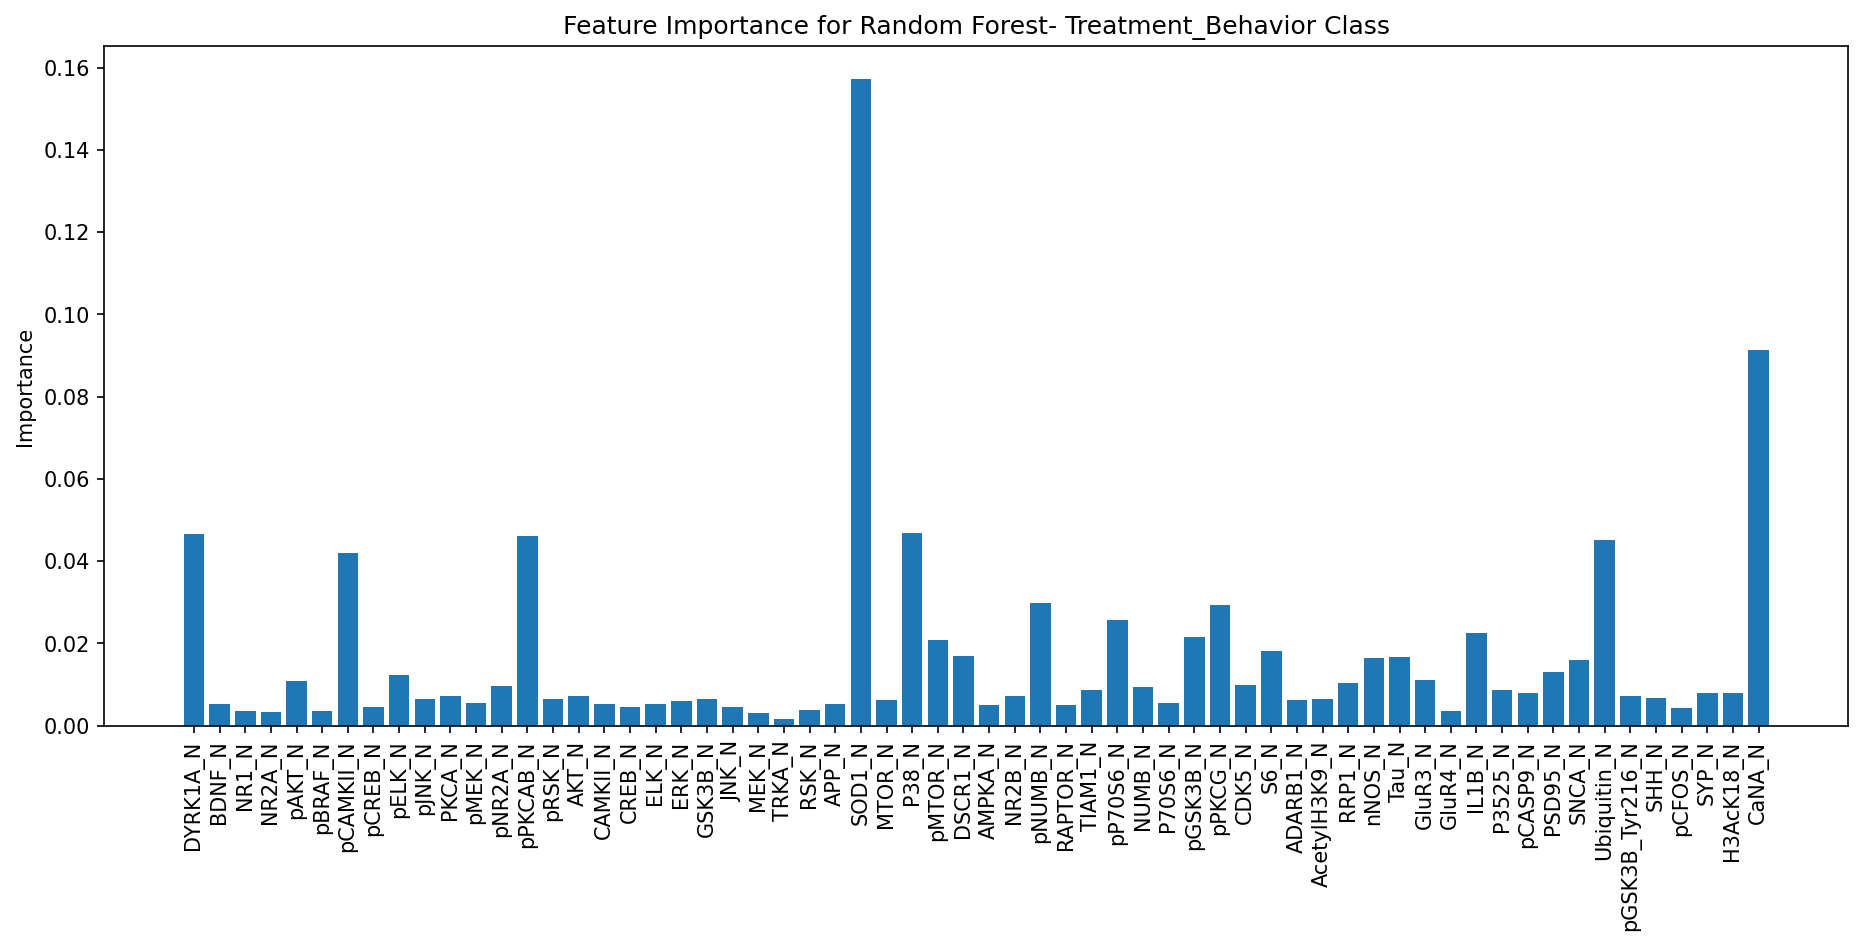

The proteins with the highest feature importance (in increasing order) are:  Index(['pPKCAB_N', 'DYRK1A_N', 'P38_N', 'CaNA_N', 'SOD1_N'], dtype='object')


In [35]:
#uses the best hyperparameters from the previously perfomed grid search operation and the trained random forest classifier
best_estimator=rf_treatment.best_estimator_ 

#obtain feature importance from built in function
rf_importance= best_estimator.feature_importances_

# Create a horizontal bar graph of the feature/protein importances
proteins = df.columns[:-2]
y_pos = np.arange(len(proteins))

#Plotting and garnishing
plt.figure(figsize=(15,6), dpi=150)
plt.bar(y_pos, rf_importance, align='center')
plt.xticks(y_pos, proteins, rotation=90)
plt.ylabel('Importance')
plt.title('Feature Importance for Random Forest- Treatment_Behavior Class')
plt.show()

sorted_importance_indices= np.argsort(rf_importance) #array of indices corresponding to increasing importance values
print("The proteins with the highest feature importance (in increasing order) are: ", proteins[sorted_importance_indices[-5:]])

# Comments on Feature Importance in different models:

## Genotype Class:
- APP_N emerges as an important feature across all models.
- TIAM1_N emerges as an important feature across all models except Random Forest.

## Treatment_Behavior Class:
- SOD1_N emerges as an important features across all models except Neural Network.

Overall there are some commonalities between the important features across models but there is also diversity. Different models pick out different features in terms of importance.

# 7) Recursive Feature Elimination with 5-fold cross validation

Reference- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

## a) Linear SVC

## Genotype Class

In [43]:
#Import necessary library
from sklearn.feature_selection import RFECV

#For Genotype class

#X: rows- samples, columns- features/dimensions
X= df.iloc[:,:-2].values #selects the 2D matrix of all useful protein values

#y1: target data for the binary classification
y1= df_encoded['Genotype'].values

#use the best hyperparameters already estimated using grid search
model = lin_genotype.best_estimator_

#Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=9)

#Define recursive feature elimination object
rfecv_linear_genotype = RFECV(model, cv=cv, scoring='recall') #using scoring method of 'recall'

# Fit RFECV to the data
rfecv_linear_genotype.fit(X, y1)

proteins = df.columns[:-2] #all the protein values

# Print the selected features/proteins
print("Selected Features/Proteins:", proteins[rfecv_linear_genotype.support_])

#Print best cross validation score before removing features
print("Cross validation score with all Features/Proteins:", lin_genotype.best_score_)

# Print the best cross-validation score with the selected features
print("Best cross-validation score with selected Features/Proteins:", rfecv_linear_genotype.score(X,y1))

Selected Features/Proteins: Index(['DYRK1A_N', 'NR1_N', 'pAKT_N', 'pCAMKII_N', 'pJNK_N', 'PKCA_N', 'AKT_N',
       'CAMKII_N', 'CREB_N', 'ELK_N', 'ERK_N', 'TRKA_N', 'APP_N', 'MTOR_N',
       'DSCR1_N', 'AMPKA_N', 'pNUMB_N', 'RAPTOR_N', 'TIAM1_N', 'pP70S6_N',
       'NUMB_N', 'P70S6_N', 'GluR3_N', 'P3525_N', 'pCASP9_N', 'SNCA_N',
       'Ubiquitin_N', 'pGSK3B_Tyr216_N', 'SYP_N', 'CaNA_N'],
      dtype='object')
Cross validation score with all Features/Proteins: 0.963100155954338
Best cross-validation score with selected Features/Proteins: 0.9868766404199475


## Result:
As can be seen from the recall scores, there is an increase in the recall scores with the selected features used as compared to all the features being used. Thus, this means that the selected features capture the essence of the data effectively.

## Treatment_Behavior class

In [44]:
#Import necessary library
from sklearn.feature_selection import RFECV

#For Treatment class

#X: rows- samples, columns- features/dimensions
X= df.iloc[:,:-2].values #selects the 2D matrix of all useful protein values

#y2: target data for multiclass classification
y2= df_encoded['Treatment_Behavior'].values

#use the best hyperparameters already estimated using grid search
model = lin_treatment.best_estimator_

#Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=9)

#Define recursive feature elimination object
rfecv_linear_treatment = RFECV(model, cv=cv, scoring='f1_weighted') #using scoring method of 'f1_weighted'

# Fit RFECV to the data
rfecv_linear_treatment.fit(X, y2)

proteins = df.columns[:-2] #all the protein values

# Print the selected features/proteins
print("Selected Features/Proteins:", proteins[rfecv_linear_treatment.support_])

#Print best cross validation score before removing features
print("Cross validation score with all Features/Proteins:", lin_genotype.best_score_)

# Print the best cross-validation score with the selected features
print("Best cross-validation score with selected Features/Proteins:", rfecv_linear_treatment.score(X,y2))

Selected Features/Proteins: Index(['NR1_N', 'NR2A_N', 'pCAMKII_N', 'pJNK_N', 'pNR2A_N', 'pPKCAB_N',
       'AKT_N', 'CAMKII_N', 'ERK_N', 'GSK3B_N', 'TRKA_N', 'APP_N', 'SOD1_N',
       'P38_N', 'DSCR1_N', 'pNUMB_N', 'S6_N', 'nNOS_N', 'Tau_N', 'IL1B_N',
       'pCASP9_N', 'SNCA_N', 'Ubiquitin_N', 'pGSK3B_Tyr216_N', 'CaNA_N'],
      dtype='object')
Cross validation score with all Features/Proteins: 0.963100155954338
Best cross-validation score with selected Features/Proteins: 1.0


# Result

As can be seen from the scores, scores with the selected features used is more than the scores for all the features being used. Thus, this means that the selected features capture the essence of the data effectively. 


## b) RBF kernel SVC

Recursive feature elimination does not work for RBF kernels as there are no 'coef' attributes which can be interpreted as importance. Roughly the same was done when permutation importance was calculated as it set the importance of not so useful features to zero. We will use the top 10 important features from permutation importance to see what the corss validation score is.

## Genotype Class

In [45]:
#Array of all the proteins
proteins=df.columns[:-2]

#Choose features with top 10 importances
sorted_importance_indices= np.argsort(rbf_gen_importance)
top_ten_features= proteins[sorted_importance_indices[-10:]]

#X: data for only selected features; rows- samples, columns- features/dimensions
X= df[top_ten_features].values

#y1: target data for the binary classification
y1= df_encoded['Genotype'].values

#choose the best hyperparameters deduced before for the pretrained model
rbf_selected_genotype= rbf_genotype.best_estimator_

#fit the model to this reduced dataset of selected features
rbf_selected_genotype.fit(X,y1)

#Print best cross validation score before removing features
print("Cross validation score with all Features/Proteins:", rbf_genotype.best_score_)

# Print the best cross-validation score with the selected features
print("Best cross-validation score with selected Features/Proteins:", rbf_selected_genotype.score(X, y1))

Cross validation score with all Features/Proteins: 0.9970588235294118
Best cross-validation score with selected Features/Proteins: 0.9409448818897638


## Result:
As can be seen from the recall scores, there is no significant drop in the recall scores with the selected features used and all the features being used. Thus, this means that the selected features capture the essence of the data effectively. 

## Treatment_Behavior Class

In [46]:
#Array of all the proteins
proteins=df.columns[:-2]

#Choose features with top 10 importances
sorted_importance_indices= np.argsort(rbf_treat_importance)
top_ten_features= proteins[sorted_importance_indices[-10:]]

#X: data for only selected features; rows- samples, columns- features/dimensions
X= df[top_ten_features].values

#y2: target data for multiclass classification
y2= df_encoded['Treatment_Behavior'].values

#choose the best hyperparameters deduced before for the pretrained model
rbf_selected_treatment= rbf_treatment.best_estimator_

#fit the model to this reduced dataset of selected features
rbf_selected_treatment.fit(X,y2)

#Print best cross validation score before removing features
print("Cross validation score with all Features/Proteins:", rbf_treatment.best_score_)

# Print the best cross-validation score with the selected features
print("Best cross-validation score with selected Features/Proteins:", rbf_selected_treatment.score(X, y2))

Cross validation score with all Features/Proteins: 0.997390509821124
Best cross-validation score with selected Features/Proteins: 0.8963254593175853


## Result:
As can be seen from the scores, there is no significant drop in the scores with the selected features used and all the features being used. Thus, this means that the selected features capture the essence of the data effectively. 

## c) Neural Network
Recursive feature elimination does not work for Neural Networks as there are no 'coef' attributes which can be interpreted as importance. Roughly the same was done when permutation importance was calculated as it set the importance of not so useful features to zero

## Genotype Class

In [47]:
#Array of all the proteins
proteins=df.columns[:-2]

#Choose features with top 10 importances
sorted_importance_indices= np.argsort(neural_gen_importance)
top_ten_features= proteins[sorted_importance_indices[-10:]]

#X: data for only selected features; rows- samples, columns- features/dimensions
X= df[top_ten_features].values

#y1: target data for the binary classification
y1= df_encoded['Genotype'].values

#choose the best hyperparameters deduced before for the pretrained model
model= neural_genotype.best_estimator_

#fit the model to this reduced dataset of selected features
model.fit(X,y1)

#Print best cross validation score before removing features
print("Cross validation score with all Features/Proteins:", neural_genotype.best_score_)

# Print the best cross-validation score with the selected features
print("Best cross-validation score with selected Features/Proteins:", model.score(X, y1))

Cross validation score with all Features/Proteins: 0.9910873440285204
Best cross-validation score with selected Features/Proteins: 0.9671916010498688


## Result:
As can be seen from the scores, there is no significant drop in the scores with the selected features used and all the features being used. Thus, this means that the selected features capture the essence of the data effectively. 

## Treatment_Behavior Class

In [48]:
#Array of all the proteins
proteins=df.columns[:-2]

#Choose features with top 10 importances
sorted_importance_indices= np.argsort(neural_treat_importance)
top_ten_features= proteins[sorted_importance_indices[-10:]]

#X: data for only selected features; rows- samples, columns- features/dimensions
X= df[top_ten_features].values

#y2: target data for multiclass classification
y2= df_encoded['Treatment_Behavior'].values

#choose the best hyperparameters deduced before for the pretrained model
model= neural_genotype.best_estimator_

#fit the model to this reduced dataset of selected features
model.fit(X,y2)

#Print best cross validation score before removing features
print("Cross validation score with all Features/Proteins:", neural_genotype.best_score_)

# Print the best cross-validation score with the selected features
print("Best cross-validation score with selected Features/Proteins:", model.score(X, y2))

Cross validation score with all Features/Proteins: 0.9910873440285204
Best cross-validation score with selected Features/Proteins: 0.8963254593175853


## Result:
As can be seen from the scores, there is no significant drop in the scores with the selected features used and all the features being used. Thus, this means that the selected features capture the essence of the data effectively. 

## d) Random Forest

## Genotype Class

In [50]:
#Import necessary library
from sklearn.feature_selection import RFECV

#For Genotype class

#X: rows- samples, columns- features/dimensions
X= df.iloc[:,:-2].values #selects the 2D matrix of all useful protein values

#y1: target data for the binary classification
y1= df_encoded['Genotype'].values

#use the best hyperparameters already estimated using grid search
model = rf_genotype.best_estimator_

#Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=9)

#Define recursive feature elimination object
rfecv_rf_genotype = RFECV(model, cv=cv, scoring='recall') #using scoring method of 'recall'

# Fit RFECV to the data
rfecv_rf_genotype.fit(X, y1)

proteins = df.columns[:-2] #all the protein values

# Print the selected features/proteins
print("Selected Features/Proteins:", proteins[rfecv_rf_genotype.support_])

#Print best cross validation score before removing features
print("Cross validation score with all Features/Proteins:", rf_genotype.best_score_)

# Print the best cross-validation score with the selected features
print("Best cross-validation score with selected Features/Proteins:", rfecv_rf_genotype.score(X,y1))

Selected Features/Proteins: Index(['DYRK1A_N', 'BDNF_N', 'NR1_N', 'NR2A_N', 'pAKT_N', 'pCAMKII_N',
       'pCREB_N', 'pELK_N', 'PKCA_N', 'pNR2A_N', 'pPKCAB_N', 'pRSK_N', 'AKT_N',
       'CAMKII_N', 'CREB_N', 'ELK_N', 'ERK_N', 'GSK3B_N', 'JNK_N', 'TRKA_N',
       'APP_N', 'SOD1_N', 'MTOR_N', 'P38_N', 'pMTOR_N', 'DSCR1_N', 'AMPKA_N',
       'NR2B_N', 'pNUMB_N', 'RAPTOR_N', 'TIAM1_N', 'pP70S6_N', 'pGSK3B_N',
       'pPKCG_N', 'S6_N', 'ADARB1_N', 'AcetylH3K9_N', 'Tau_N', 'GluR3_N',
       'GluR4_N', 'IL1B_N', 'P3525_N', 'pCASP9_N', 'PSD95_N', 'Ubiquitin_N',
       'pGSK3B_Tyr216_N', 'pCFOS_N', 'SYP_N', 'H3AcK18_N', 'CaNA_N'],
      dtype='object')
Cross validation score with all Features/Proteins: 0.9758294520154103
Best cross-validation score with selected Features/Proteins: 1.0


## Result:
As can be seen from the recall scores, there is no significant drop in the recall scores with the selected features used and all the features being used. In fact, there is a slight increase. Thus, this means that the selected features capture the essence of the data effectively.

## Treatment_Behavior class

In [51]:
#Import necessary library
from sklearn.feature_selection import RFECV

#For Treatment class

#X: rows- samples, columns- features/dimensions
X= df.iloc[:,:-2].values #selects the 2D matrix of all useful protein values

#y2: target data for multiclass classification
y2= df_encoded['Treatment_Behavior'].values

#use the best hyperparameters already estimated using grid search
model = rf_treatment.best_estimator_

#Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=9)

#Define recursive feature elimination object
rfecv_rf_treatment = RFECV(model, cv=cv, scoring='f1_weighted') #using scoring method of 'f1_weighted'

# Fit RFECV to the data
rfecv_rf_treatment.fit(X, y2)

proteins = df.columns[:-2] #all the protein values

# Print the selected features/proteins
print("Selected Features/Proteins:", proteins[rfecv_rf_treatment.support_])

#Print best cross validation score before removing features
print("Cross validation score with all Features/Proteins:", rf_treatment.best_score_)

# Print the best cross-validation score with the selected features
print("Best cross-validation score with selected Features/Proteins:", rfecv_rf_treatment.score(X,y2))

Selected Features/Proteins: Index(['DYRK1A_N', 'BDNF_N', 'pAKT_N', 'pBRAF_N', 'pCAMKII_N', 'pCREB_N',
       'pELK_N', 'pJNK_N', 'PKCA_N', 'pMEK_N', 'pNR2A_N', 'pPKCAB_N', 'pRSK_N',
       'AKT_N', 'CAMKII_N', 'ELK_N', 'ERK_N', 'GSK3B_N', 'JNK_N', 'MEK_N',
       'APP_N', 'SOD1_N', 'MTOR_N', 'P38_N', 'pMTOR_N', 'DSCR1_N', 'NR2B_N',
       'pNUMB_N', 'RAPTOR_N', 'TIAM1_N', 'pP70S6_N', 'NUMB_N', 'P70S6_N',
       'pGSK3B_N', 'pPKCG_N', 'CDK5_N', 'S6_N', 'ADARB1_N', 'AcetylH3K9_N',
       'RRP1_N', 'nNOS_N', 'Tau_N', 'GluR3_N', 'GluR4_N', 'IL1B_N', 'P3525_N',
       'pCASP9_N', 'PSD95_N', 'SNCA_N', 'Ubiquitin_N', 'pGSK3B_Tyr216_N',
       'SHH_N', 'SYP_N', 'H3AcK18_N', 'CaNA_N'],
      dtype='object')
Cross validation score with all Features/Proteins: 0.9921546487293238
Best cross-validation score with selected Features/Proteins: 1.0


# Result

As can be seen from the scores, scores with the selected features used is more than the scores all the features being used. Thus, this means that the selected features capture the essence of the data effectively. 

# 8) Test a few promising models

The Linear SVC and Random Forest Classifier emerge as promising models in classifying the two classes. RBF Kernel SVC has a tendency of overfitting the data while neural network is giving a poor performance comparitively.

## Prepare the test data

In [53]:
#read the test data file and store in a pandas data frame
df_test= pd.read_csv('MouseTest.csv') 

In [54]:
#use the same features as used for the initial training set
df_test=df_test[df.columns]

In [55]:
# Impute the missing values if any

#Multivariate imputation of missing data
impute = IterativeImputer(max_iter=10, random_state=0) #initialize the iterative imputer
impute.fit(df_test[df_test.columns[:-2]]) #train the multivariate imputation model on all the data of the proteins. [:-2] chooses all columns except the last 2 as they are classes

df_test.iloc[:,:-2]= impute.transform(df_test[df_test.columns[:-2]]) #fill up the missing values based on the trained model and replace the protein data

In [56]:
#Encode the data of two classes
df_test_encoded=df_test #make a copy of the dataset to encode

#Replace the two classes of Genotype class with 0,1
df_test_encoded['Genotype'].replace(['Control', 'Ts65Dn'], [0, 1], inplace=True) 

#Replace the four classes of Treatment_Behaviour class with 0,1,2,3
df_test_encoded['Treatment_Behavior'].replace(['Memantine_C/S', 'Memantine_S/C', 'Saline_C/S', 'Saline_S/C'], [0, 1, 2, 3], inplace=True)

In [57]:
#Normalise the test data with the same parameters as the training data
df_test[columns_to_normalize] = scaler.transform(df_test[columns_to_normalize])

## Linear SVC (with best features and best hyperparamters)

In [58]:
#Genotype Class

#Training data
X_train= df.iloc[:,:-2].values

y_train= df_encoded['Genotype'].values

#Test data
X_test= df_test.iloc[:,:-2].values

y_test= df_test_encoded['Genotype'].values

#Training score with optimal features
train_score= rfecv_linear_genotype.score(X_train,y_train) #automatically selects best subset

#Test score with optimal features
test_score= rfecv_linear_genotype.score(X_test,y_test) #automatically selects best subset

#Print both the results for comparison
print("Recall score on the training data (Genotype Class):", train_score)

print("Recall score on the test data (Genotype Class):", test_score)

#Treatment_Behavior Class

#Training data
X_train= df.iloc[:,:-2].values

y_train= df_encoded['Treatment_Behavior'].values

#Test data
y_test= df_test_encoded['Treatment_Behavior'].values

X_test= df_test.iloc[:,:-2].values

#Training score with optimal features
train_score= rfecv_linear_treatment.score(X_train,y_train) #automatically selects best subset

#Test score with optimal features
test_score= rfecv_linear_treatment.score(X_test,y_test) #automatically selects best subset

#Print both the results for comparison
print("F1 score on the training data (Treatment_Behavior Class):", train_score)

print("F1 score on the test data (Treatment_Behavior Class):", test_score)


Recall score on the training data (Genotype Class): 0.9868766404199475
Recall score on the test data (Genotype Class): 0.7688888888888888
F1 score on the training data (Treatment_Behavior Class): 1.0
F1 score on the test data (Treatment_Behavior Class): 0.8933333333333333


# Results:
- There is good test performance of Linear SVC for classifying the genotype class 
- There is good test performance of Linear SVC for classifying the Treatment_Behavior class 

## Random Forest (with best features and best hyperparamters)

In [59]:
#Genotype Class

#Training data
X_train= df.iloc[:,:-2].values

y_train= df_encoded['Genotype'].values

#Test data
X_test= df_test.iloc[:,:-2].values

y_test= df_test_encoded['Genotype'].values

#Training score with optimal features
train_score= rfecv_rf_genotype.score(X_train,y_train) #automatically selects best subset

#Test score with optimal features
test_score= rfecv_rf_genotype.score(X_test,y_test) #automatically selects best subset

#Print both the results for comparison
print("Recall score on the training data (Genotype Class):", train_score)

print("Recall score on the test data (Genotype Class):", test_score)

#Treatment_Behavior Class

#Training data
X_train= df.iloc[:,:-2].values

y_train= df_encoded['Treatment_Behavior'].values

#Test data
y_test= df_test_encoded['Treatment_Behavior'].values

X_test= df_test.iloc[:,:-2].values

#Training score with optimal features
train_score= rfecv_rf_treatment.score(X_train,y_train) #automatically selects best subset

#Test score with optimal features
test_score= rfecv_rf_treatment.score(X_test,y_test) #automatically selects best subset

#Print both the results for comparison
print("F1 score on the training data (Treatment_Behavior Class):", train_score)

print("F1 score on the test data (Treatment_Behavior Class):", test_score)



Recall score on the training data (Genotype Class): 1.0
Recall score on the test data (Genotype Class): 0.7688888888888888
F1 score on the training data (Treatment_Behavior Class): 1.0
F1 score on the test data (Treatment_Behavior Class): 0.7466666666666667


# Results:
- There is good test performance of Random Forest Classifier for classifying the genotype class 
- There is good test performance of Random Forest Classifier for classifying the Treatment_Behavior class 

# Objective 2: 

## Practice using pre-trained neural networks to extract domain-specific features for new tasks

# 9) ConvNet as fixed feature extractor (Testing whether code works)
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
#Load necessary libraries

# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

### Load data

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize images

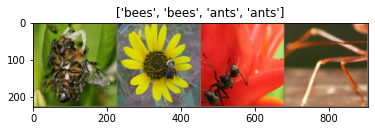

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Function to train the model

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Load a pretrained model

In transfer learning, the pre-trained CNN model is often used as a fixed feature extractor, and only the newly added fully connected layer is trained on the new dataset for the new task. By replacing the final fully connected layer with a new layer that has the appropriate number of output features, the model can be fine-tuned for a new classification task.

In [72]:
model_conv = torchvision.models.resnet18(pretrained=True)#loads the pre-trained ResNet18 model from the PyTorch model zoo
#The pretrained parameter is set to True, which means that the weights of the pre-trained model are loaded.

#Freeze all the parameters of the neural network
for param in model_conv.parameters():
    param.requires_grad = False
    
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features #all the features of the neural network
model_conv.fc = nn.Linear(num_ftrs, 2)
#The above line replaces the final fully connected layer of a pre-trained convolutional neural network (CNN) model
#with a new fully connected layer that has 2 output features. Only the parameters of this new layer will be trained

model_conv = model_conv.to(device) # moves the ResNet18 model to the specified device 

#set the loss function
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

In [73]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7227 Acc: 0.6148
val Loss: 0.2014 Acc: 0.9542

Epoch 1/24
----------
train Loss: 0.5030 Acc: 0.7623
val Loss: 0.1690 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.4629 Acc: 0.7787
val Loss: 0.2204 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.4382 Acc: 0.7910
val Loss: 0.1845 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.4642 Acc: 0.8074
val Loss: 0.1773 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.3832 Acc: 0.8197
val Loss: 0.1878 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.3607 Acc: 0.8443
val Loss: 0.2348 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.3498 Acc: 0.8279
val Loss: 0.2134 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.2932 Acc: 0.8648
val Loss: 0.2039 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3402 Acc: 0.8770
val Loss: 0.1865 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.4054 Acc: 0.8033
val Loss: 0.1981 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.4324 Acc: 0.7910
val Loss: 0.2012 Acc: 0.9477

Ep

## Comments:
The example tutorial for using ConvNet as a fixed feature extractor works on the local machine. Instead of using the last layer for classifying ants and bees as in the tutorial, we will just extract the features and use it for our training purposes. 

# 10) Function that outputs ResNet18 features for a given input image

In [5]:
import torch
import torchvision.models as models

def extract_resnet_features(image):
    # Load pre-trained ResNet18 model
    model = models.resnet18(pretrained=True)
    
    # Remove the final fully connected layer
    model = torch.nn.Sequential(*list(model.children())[:-1])
    
    #Move the model to device
    model.to(device)

    # Add an extra batch dimension to the input tensor as input to resnet model is 4D
    input_batch = image.unsqueeze(0)

    # Pass the input batch through the ResNet18 model
    with torch.no_grad():
    #no need to calculate gradients as only output features needed
        resnet_features = model(input_batch.to(device))

    # Flatten the output tensor into a 1D array
    resnet_features = torch.flatten(resnet_features, start_dim=1)

    # Return the extracted ResNet18 features as a NumPy array
    return resnet_features.cpu().numpy()

In [6]:
#empty list to store resnet features
resnet_features_train = []
target_vector_train= []
for image, label in image_datasets['train']:
    #loop over all images in training image set
    
    #pass the image to previously defined function that ouptputs the features for that image
    features = extract_resnet_features(image)
    
    #append the features to the list
    resnet_features_train.append(features)
    
    #append label to target vector list
    target_vector_train.append(label)

#There is a dummy dimension that has to be removed
extracted_train_features= np.array(resnet_features_train)[:,0,:]
target_vector_train=np.array(target_vector_train) #convert to numpy array

print(extracted_train_features.shape)
print(target_vector_train.shape)

/Users/vaishnavrao/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vaishnavrao/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(244, 512)
(244,)


## Result:
The features dataset is a 244x512 dimension array as expected. 244 is the number of images in the training set. 512 is the number of ResNet features

# 11) Training on different models

In [23]:
#Training data

X_train= extracted_train_features
y_train= target_vector_train

In [24]:
#Test data

#empty list to store resnet features
resnet_features_test = []
target_vector_test= []

for image, label in image_datasets['val']:
    #loop over all images in validation image set
    
    #pass the image to previously defined function that ouptputs the features for that image
    features = extract_resnet_features(image)
    
    #append the features to the list
    resnet_features_test.append(features)
    
    #append label to target vector list
    target_vector_test.append(label)

#There is a dummy dimension that has to be removed
extracted_test_features= np.array(resnet_features_test)[:,0,:]

target_vector_test=np.array(target_vector_test) #convert to numpy array

X_test= extracted_test_features
y_test= target_vector_test

/Users/vaishnavrao/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vaishnavrao/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
#Scale and normalize training and test data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

## L2- regularized logistic regression

Reference- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Set up the logistic regression model
log_reg = LogisticRegression(penalty='l2', solver='lbfgs')

#Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=57)

# Set up the parameter grid for grid search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Set up the grid search cross-validation object
logistic_model = GridSearchCV(log_reg, param_grid=param_grid, cv=cv, scoring='roc_auc')

# Fit the grid search object to the data
logistic_model.fit(X_train, y_train)

# Print the best parameter and score
print("Best parameter: ", logistic_model.best_params_)
print("Best score: ", logistic_model.best_score_)


Best parameter:  {'C': 0.01}
Best score:  0.7364448722339374


In [39]:
from sklearn.metrics import accuracy_score, f1_score

y_pred_train= logistic_model.best_estimator_.predict(X_train)
y_pred_test = logistic_model.best_estimator_.predict(X_test)

print("Accuracy-", "Training:", accuracy_score(y_train, y_pred_train),  "Test:", accuracy_score(y_test, y_pred_test))
print("F1 score-", "Training:", f1_score(y_train, y_pred_train),  "Test:", f1_score(y_test, y_pred_test))


Accuracy- Training: 0.9959016393442623 Test: 0.6274509803921569
F1 score- Training: 0.995850622406639 Test: 0.6705202312138728


## RBF Kernel SVC

In [40]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=69)

#Define a dictionary of hyperparameters to search over
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'gamma': [0.01, 0.1, 1, 10]}

#Create an instance of the SVM classifier
svm = SVC(kernel='rbf') #RBF kernels

#Create an instance of the GridSearchCV class
rbf_model = GridSearchCV(svm, param_grid, cv=cv, scoring='roc_auc') 

#Fit the GridSearchCV object to the data
rbf_model.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print('Best parameters:', rbf_model.best_params_)
print('Best score:', rbf_model.best_score_)


Best parameters: {'C': 1, 'gamma': 0.01}
Best score: 0.7212661058748016


In [41]:
from sklearn.metrics import accuracy_score, f1_score

y_pred_train= rbf_model.best_estimator_.predict(X_train)
y_pred_test = rbf_model.best_estimator_.predict(X_test)

print("Accuracy-", "Training:", accuracy_score(y_train, y_pred_train),  "Test:", accuracy_score(y_test, y_pred_test))
print("F1 score-", "Training:", f1_score(y_train, y_pred_train),  "Test:", f1_score(y_test, y_pred_test))

Accuracy- Training: 1.0 Test: 0.45751633986928103
F1 score- Training: 1.0 Test: 0.0


## Random Forest

In [46]:
#import necessary library
from sklearn.ensemble import RandomForestClassifier

#Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=37)

# Set up the Random Forest Classifier
rf_class = RandomForestClassifier(criterion='entropy') 

# Set up the hyperparameter grid
param_grid = {
    'max_depth': [1,10,20,30],
    'max_features': [1,10,20,30]
}

#initialize GridSearchCV object
rf_model = GridSearchCV(rf_class, param_grid=param_grid, cv=cv) 

#Fit the GridSearchCV object to the data
rf_model.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best parameters: {rf_model.best_params_}")
print(f"Best score: {rf_model.best_score_:.2f}")

Best parameters: {'max_depth': 20, 'max_features': 10}
Best score: 0.68


In [47]:
from sklearn.metrics import accuracy_score, f1_score

y_pred_train= rf_model.best_estimator_.predict(X_train)
y_pred_test = rf_model.best_estimator_.predict(X_test)

print("Accuracy-", "Training:", accuracy_score(y_train, y_pred_train),  "Test:", accuracy_score(y_test, y_pred_test))
print("F1 score-", "Training:", f1_score(y_train, y_pred_train),  "Test:", f1_score(y_test, y_pred_test))

Accuracy- Training: 1.0 Test: 0.5947712418300654
F1 score- Training: 1.0 Test: 0.6265060240963856


# 12) Key Findings:

Overall there is good performance in accuracy and F1_score on the training data but there is quite poor performance on the test data for all the models. The worst overfitting is occuring with RBF kernels. There is possibly **overfitting** due to the number of features being more than the number of samples for training. Though there is a possibility that I'm missing something and there is an error in my code or logic, I havent been able to figure out anything wrong after having spent 4 days trying to find a mistake.

# Acknowledgements:

- ChatGPT of OpenAI was used to see examples for and properly implement the syntax of the code for inbuilt functions. For example, in the code blocks to perform GridSearchCV and RFECV, the AI was used to output example codes which utilised the libraries and functions of 'sklearn'. The websites and references used for particular codeblocks have been linked in the respective blocks themselves.